# Detecting Implicit Bias in Police Traffic Stops

With the increasing awareness of difficult encounters between law enforcement and members of minority communities, many have called for changes in the way police officers are trained and monitored in their dealings with the public.
In any area of human interaction, one of the most difficult problems to detect is implicit bias. This project will first determine whether implicit bias is present in police-motorist interactions; it will then examine, through modeling, the influence of any such bias on outcomes, relative to other relevant parameters.

This study was conducted using police traffic stop data collected between the October 1st, 2013 and September 30, 2015 and posted online by the Connecticut Racial Profiling Prohibition Project. The aim of the project is to monitor and combat racial profiling in interactions between the police and road users.
<div class="alert alert-block alert-success">(http://ctrp3.ctdata.org/)</div>

The data cover the period between October 2013 and September 2015. The dataset consists of over 800,000 individal records, each representing a single traffic stop. The data recorded for each stop included the time, day and date of the stop, the age, race, sex of the subject, and state and local residency of the subject. Further information include the police department, officer ID, reason for the stop, whether the car was searched, and many other important pieces of information. The raw data can be found by visiting the CRPPP website or at the following link:

<div class="alert alert-block alert-success">(http://ctrp3viz.s3.amazonaws.com/data/Connecticut_102013_32015.csv)</div>

Ths study will clean, analyze and interpret the data, the aim being to arrive at a better understanding of the factors that drive interactions between the police and motorists in the State of Connecticut. In particular, we will address two key issues, each of which is presented in the form of a hypothesis:

### Hypotheses

<div class="alert alert-block alert-info"> 
1. Racial bias plays a role in at least some aspects of some interactions on the road between police and motorists.

</div>



<div class="alert alert-block alert-info">

2. The outcome of interactions between police and motorists can be statistically modeled and predicted as a function of demographic factors, specifically race.
</div>

The data cleaning and table manipulation used in this study are shown below. You may wish to skip straight to the [Analysis](#Analysis). Details on the supervised learning models used can be found in the [Modeling section](#Modeling). The overall wrap-up, including conclusions and discussion, start in the [Results section](#Results).

### Dataset Characteristics
The original dataset contained a number of problems, which had to be addressed before the analysis could begin. These included:

-  Missing fields. Rows containing missing fields, in columns that were material to the analysis, were removed. 

-  Unfeasibly high or low values. An example of this is the age column, which had a number of values up to 250 and below 10 years of age. Since there was no sure way to know what the true value was meant to be when entered into the system, these values were set to the (dataset) population mean. 
-  Columns deemed unnecessary for the analysis being undertaken. These were simply removed from the dataset.
-  Columns stored as 'object' datatypes. In order to streamline the dataframe and make it more manageable, these columns were changed to the 'category' datatype. This led to considerable reduction in the size of the dataframe.

Shown below are the characteristics of the final dataset after all cleaning had been completed:

#### Time Period: October 1st, 2013 to September 30, 2015

#### Number of Records: 857,895

#### Fields:

-  Department             
-  Officer carrying out the stop
-  Month          
-  Race of Subject
-  Ethnicity of Subject
-  Sex of Subject
-  Age of Subject
-  Subject Resident in State (Yes or No)
-  Subject Resident in Town (Yes or No)
-  Location (Town)
-  Reason for Stop
-  Stop Technique 
-  Duration of Stop
-  Car Towed (Yes or No)
-  Statute Reason (Reason for Stop)
-  Vehicle Searched (Yes or No)
-  Authorization for Search (e.g. Consent Given ot Not)
-  Contraband (If Searched, Was any Found)
-  Arrest (Yes or No)
-  Disposition (Outcome of Stop - Verbal Warning, Court Summons etc.)
-  Hour
-  Day of Month
-  Day of Week
---

### Import Required Packages

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import time

from pylab import *
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from IPython.display import Image
plt.style.use(['fivethirtyeight'])

%matplotlib inline
warnings.filterwarnings('ignore')

In [190]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', '_classic_test']


### Data Import and Cleaning

In [191]:
stop = pd.read_csv('C://Users//fergu//Connecticut_102013_32015.csv', encoding='Latin1')
stop.head()

,CreatedDate,ProfileNo,OrganizationIdentificationID,Department Name,OrganizationActivityText,ReportingOfficerIdentificationID,InterventionIdentificationID,IdentificationCategoryDescriptionText,InterventionDate,Month,...,InterventionDispositionDate,InterventionDispositionReasonText,IsStatuteCodeValid,IsStatutatoryCitationValid,IsaTest,RecordCount,SourceId,SourceReferenceId,InterventionDateTime,InterventionTime
0,1/7/14 16:24,74976,CT0001400,Branford,Racial Profile,378,1300024756,Incident ID,"Tuesday, October 01, 2013",October,...,NaN,NaN,NaN,NaN,False,1.0,CT0001400,974fd8c4-2798-48c5-8b07-5e2119b0b757,10/1/13 12:52,12:52:01 PM
1,1/10/14 9:48,90714,CTCSP1000,State Police,Racial Profile,1000001940,1300616313,Incident ID,"Tuesday, October 01, 2013",October,...,NaN,NaN,NaN,NaN,False,1.0,CTCSP0000,1.30338E+17,10/1/13 14:38,2:38:06 PM
2,1/10/14 9:48,92410,CTCSP0600,State Police,Racial Profile,1000002349,1300616887,Incident ID,"Tuesday, October 01, 2013",October,...,NaN,NaN,NaN,NaN,False,1.0,CTCSP0000,1.30338E+17,10/1/13 20:25,8:25:01 PM
3,1/10/14 9:49,95300,CTCSP0700,State Police,Racial Profile,987312802,1300615169,Incident ID,"Tuesday, October 01, 2013",October,...,NaN,NaN,NaN,NaN,False,1.0,CTCSP0000,1.30338E+17,10/1/13 2:11,2:11:27 AM
4,1/7/14 16:24,74933,CT0001400,Branford,Racial Profile,1051,1300024738,Incident ID,"Tuesday, October 01, 2013",October,...,NaN,NaN,NaN,NaN,False,1.0,CT0001400,974fd8c4-2798-48c5-8b07-5e2119b0b757,10/1/13 9:35,9:35:22 AM


In [192]:
# Check for missingness
stop.isnull().sum()

CreatedDate                                 967
ProfileNo                                  4191
OrganizationIdentificationID                  1
Department Name                               1
OrganizationActivityText                      1
ReportingOfficerIdentificationID              3
InterventionIdentificationID               2534
IdentificationCategoryDescriptionText         1
InterventionDate                              1
Month                                         1
SubjectRaceCode                               1
SubjectEthnicityCode                          1
SubjectSexCode                                1
SubjectAge                                  202
ResidentIndicator                             2
TownRecidentIndicator                         6
InterventionLocationName                      1
InterventionLocationDescriptionText         761
InterventionLocationLatitude              21004
InterventionLocationLongitude             21004
InterventionReasonCode                  

In [193]:
# Check size of dataframe
len(stop)

857895

In [194]:
# Remove unnecessary columns
columns_to_drop = ['CreatedDate', 'ProfileNo', 'OrganizationActivityText', 
                   'IdentificationCategoryDescriptionText', 'InterventionLocationDescriptionText',
                   'InterventionIdentificationID', 'StatutatoryCitation', 'InterventionDispositionDate', 
                   'InterventionDispositionReasonText', 'IsStatuteCodeValid', 
                   'IsStatutatoryCitationValid', 'InterventionDateTime', 
                   'SourceId', 'SourceReferenceId']    
stop.drop(columns_to_drop, axis=1, inplace=True)

In [195]:
# Give the remaining columns shorter/ more helpful names
new_names = ['org_id', 'dept', 'officer', 'date', 'month', 'race', 'eth', 
             'sex', 'age', 'res', 'town_res', 'location', 'lat', 'long', 
             'reason', 'technique', 'duration', 'towed', 'statute', 
             'statute_reason', 'veh_searched', 'auth_search', 'contraband',
             'arrest', 'disposition', 'isatest', 'record_count', 'time']
stop.columns = new_names

In [196]:
# Give in-table values more descriptive names
stop['race'].replace(['W', 'B', 'A', 'I'], ['white', 'black', 'asian', 'native'], inplace=True)
stop['eth'].replace(['M', 'H', 'N', 'm'], ['middle-east', 'hispanic', 'non-hispanic', 'middle-east'], 
                    inplace=True)
stop['sex'].replace(['M', 'F'], ['male', 'female'], inplace=True)
stop['reason'].replace(['V', 'E', 'I', 'no'], ['vehicle', 'equipment', 'investigative', 'vehicle'], 
                       inplace=True)
stop['disposition'].replace(['I', 'I ', 'V', 'W', 'M', 'N', 'U'], 
                            ['infraction', 'infraction', 'verbal_w', 'written_w', 'misdemeanor_summ', 
                             'no_disposition', 'uniform_arrest'], inplace=True)

In [197]:
stop.reset_index()
stop.index

RangeIndex(start=0, stop=857895, step=1)

In [198]:
# Create 'latino' as 'race' using the ethnicity column
stop['race'] = ['latino' if (stop['race'][i] == 'white') & (stop['eth'][i] == 'hispanic') else 
                stop['race'][i] for i in range(0, len(stop['race']))] 

In [199]:
# fill null values in lat, long columns in case they are to be used in future
latlong = stop[['lat', 'long']]
latlong.fillna('TBD', inplace=True)

In [200]:
# Drop all null rows. Default how=any
stop.dropna(inplace=True)

In [201]:
# Check size of database
len(stop)

835774

In [202]:
stop.head()

,org_id,dept,officer,date,month,race,eth,sex,age,res,...,statute,statute_reason,veh_searched,auth_search,contraband,arrest,disposition,isatest,record_count,time
0,CT0001400,Branford,378,"Tuesday, October 01, 2013",October,white,non-hispanic,female,36,True,...,14-100a(c)(1),Seatbelt,False,N,False,False,verbal_w,False,1.0,12:52:01 PM
1,CTCSP1000,State Police,1000001940,"Tuesday, October 01, 2013",October,white,middle-east,male,46,True,...,14-298,Other,False,N,False,False,verbal_w,False,1.0,2:38:06 PM
2,CTCSP0600,State Police,1000002349,"Tuesday, October 01, 2013",October,latino,hispanic,female,33,True,...,14-100a(d),Seatbelt,False,N,False,False,infraction,False,1.0,8:25:01 PM
3,CTCSP0700,State Police,987312802,"Tuesday, October 01, 2013",October,black,non-hispanic,male,64,True,...,14-298,Other,False,N,False,False,infraction,False,1.0,2:11:27 AM
4,CT0001400,Branford,1051,"Tuesday, October 01, 2013",October,white,non-hispanic,male,49,True,...,14-18(A),Display of Plates,False,N,False,False,no_disposition,False,1.0,9:35:22 AM


### Efficiency Measures
Some steps were taken to reduce the size of the database, thereby improving its overall speed and efficiency. These included:

1. Removing attributes that were not relevant or were not going to be useful in the analysis.
2. Removing rows with missing data in key fields.
3. Changing categorical attributes from 'object' to 'category' datatype. 
4. Removing empty space from strings and converting strings to lower case where necessary, thereby ensuring that there were no duplicate names.

In [203]:
# Check which variables are categorical and how many unique values they each have
# The ones with many unique values make the dataframe very large and slow
categorical = stop.select_dtypes(include=['object'])
categorical.columns

uniques = pd.DataFrame()
uni_val = []

for col in categorical.columns:
    uni_val.append(categorical[col].nunique())
uniques['obj_column_name'] = categorical.columns
uniques['unique values'] = uni_val
uniques

,obj_column_name,unique values
0,org_id,169
1,dept,104
2,officer,5887
3,date,547
4,month,12
5,race,5
6,eth,3
7,sex,2
8,age,250
9,res,2


In [204]:
# Check number of unique location (town) names
stop['location'].nunique()

863

In [205]:
# Change all to lower case
stop['location'] = stop['location'].str.lower()
# Remove all leading and trailing spaces from location names
stop['location'] = stop['location'].str.strip()
# See reduction in no. of unique locations
stop['location'].nunique()

311

In [206]:
# Create individual hour, monthday and weekday variables
stop['hour'] = pd.to_datetime(stop['time']).dt.hour

In [207]:
stop['monthday'] = pd.to_datetime(stop['date']).dt.day

In [208]:
stop['weekday'] = pd.to_datetime(stop['date']).dt.weekday

In [209]:
# Convert age to a numeric field
stop['age'] = pd.to_numeric(stop['age'], errors='coerce')

In [210]:
# Remove further unnecessary columns including date and time
stop.drop(['org_id', 'date', 'lat', 'long', 'statute', 'record_count', 
           'isatest', 'record_count', 'time'], axis=1, inplace=True)

In [211]:
# Convert boolean columns to 0, 1:
cols= ['veh_searched', 'contraband', 'arrest', 'res', 'town_res', 'towed']
for col in cols:
    stop[col] = [1 if value == True else 0 for value in stop[col]]

In [212]:
# Convert to category datatype to save space:
cols_to_cat = ['officer', 'dept', 'month', 'race', 'eth', 'sex', 
               'location', 'reason', 'technique',
               'statute_reason', 'auth_search', 'disposition']
for col in cols_to_cat:
    stop[col] = stop[col].astype('category')

In [213]:
# Note reduction in dataframe size to 88 MB
# (from an initial 2.1 GB)
stop.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835774 entries, 0 to 857894
Data columns (total 23 columns):
dept              835774 non-null category
officer           835774 non-null category
month             835774 non-null category
race              835774 non-null category
eth               835774 non-null category
sex               835774 non-null category
age               835774 non-null float64
res               835774 non-null int64
town_res          835774 non-null int64
location          835774 non-null category
reason            835774 non-null category
technique         835774 non-null category
duration          835774 non-null float64
towed             835774 non-null int64
statute_reason    835774 non-null category
veh_searched      835774 non-null int64
auth_search       835774 non-null category
contraband        835774 non-null int64
arrest            835774 non-null int64
disposition       835774 non-null category
hour              835774 non-null int64
monthday 

## Analysis

### High-Level Breakdown of the Data - By Race, Ethnicity, and Sex

In [214]:
def pie_chart(df, col, labs, title):
    pie(df[col].value_counts(),labels=labs,autopct='%1.1f%%')
    plt.title(title)
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 22}
    matplotlib.rcParams['axes.titlepad'] = 2
    matplotlib.rc('font', **font) 

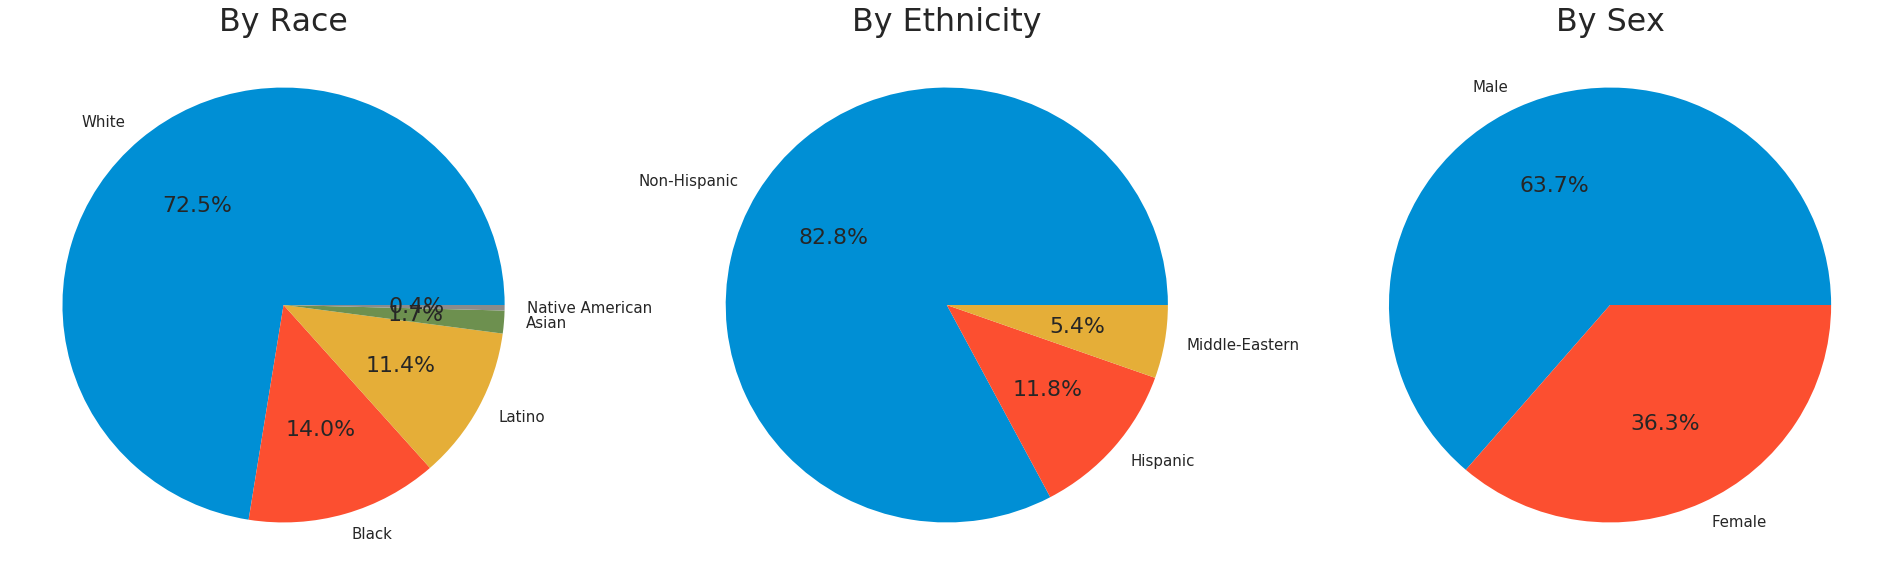

In [216]:
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plt.subplot(1,3,1)
pie_chart(stop, 'race', ['White', 'Black', 'Latino', 'Asian', 'Native American'], 'By Race')
plt.subplot(1,3,2)
pie_chart(stop, 'eth', ['Non-Hispanic', 'Hispanic', 'Middle-Eastern'], 'By Ethnicity')
plt.subplot(1,3,3)
pie_chart(stop, 'sex', ['Male', 'Female'], 'By Sex')
plt.show()

### Racial Breakdown vs. Percentage of Overall Population

In the plot below, we compare the numbers of stops, broken down by race, with 2016 census population totals for each racial group. Shown above each blue bar, a ratio is shown. This ratio represents that racial group's proportion of total traffic stops, divided by that racial group's proportion of the overall population. A number of 1.0 indicates that members of a given racial group are being stopped at levels in proportion to their percentage of the overall CT population. Here we are assuming  that the total miles driven for each racial group are commensurate with that group's proportion of the overall population. We further assume that no major demographic changes occurred between 2013 and 2016. The Connecticut population data were obtained at the following link:<BR/> <div class="alert alert-block alert-success">http://worldpopulationreview.com/states/connecticut-population/</div> 

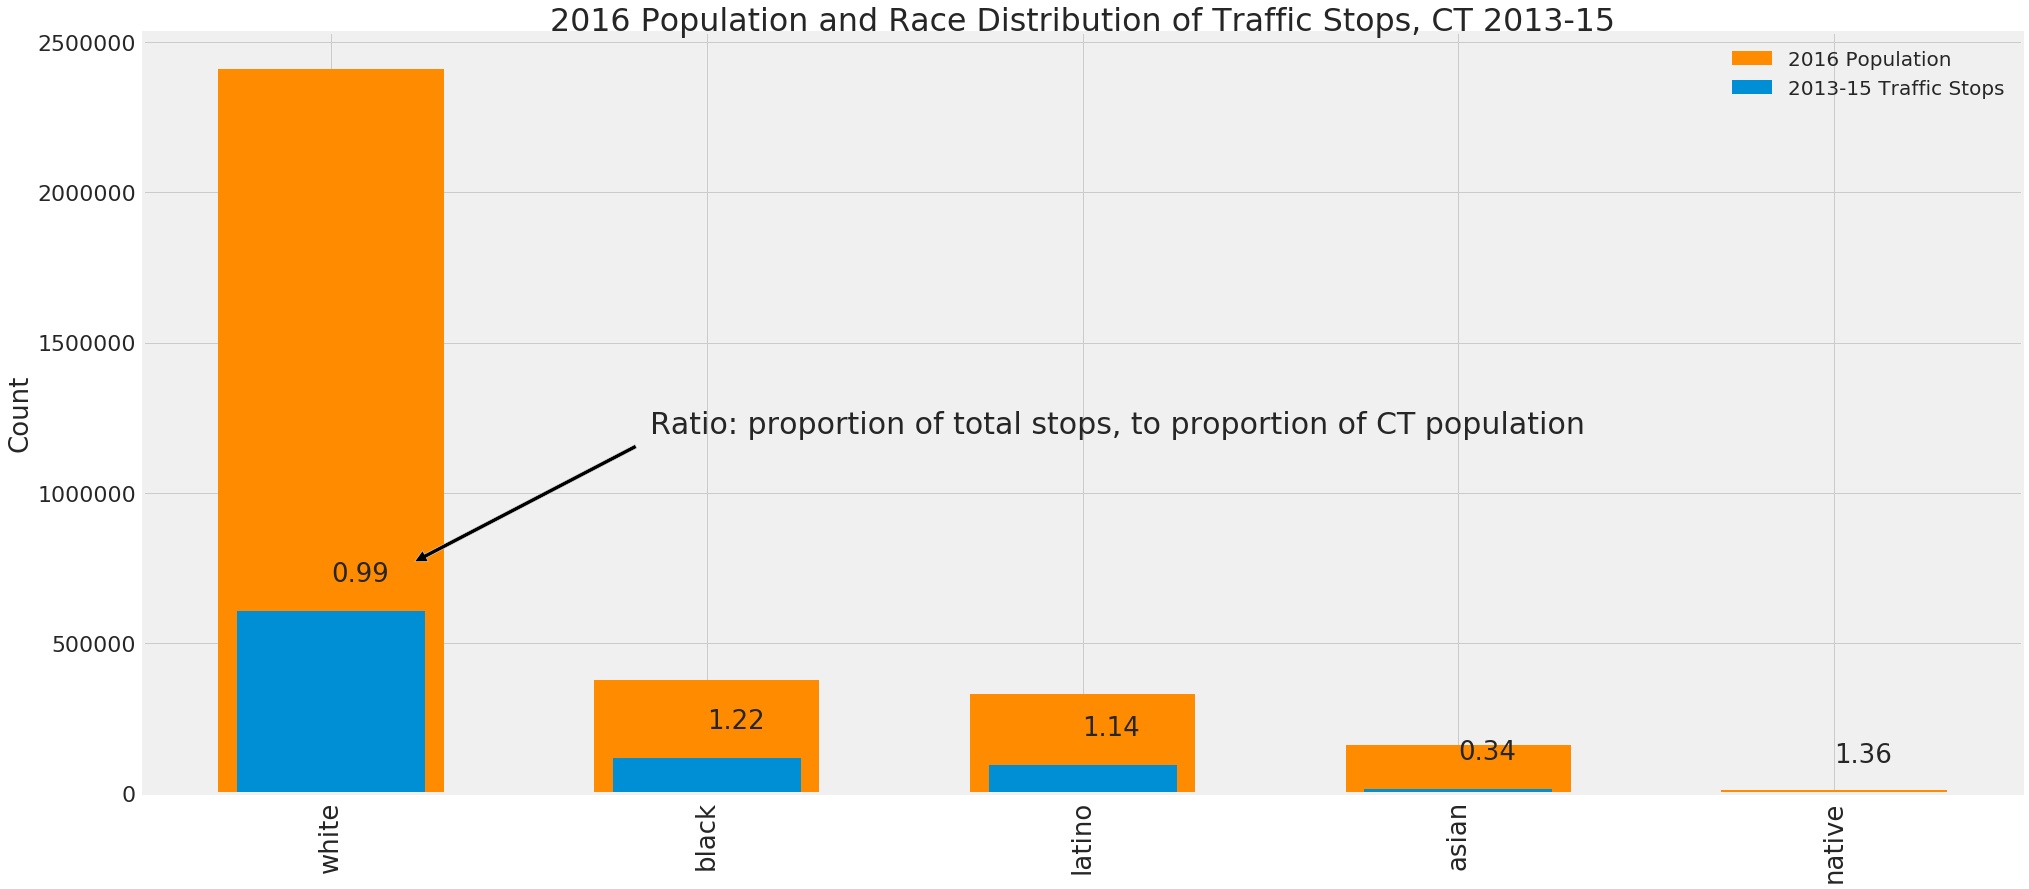

In [104]:
plt.rcParams['figure.figsize'] = (30.0, 14.0)
sum_pop = 2411769 + 378932 + 330123 + 161950 + 9887
sum_stops = 605708 + 117412 + 95110 + 14142 + 3402
CT_pop = pd.DataFrame({'pop':[2411769, 378932, 330123, 161950, 9887],
                       'pop_propor':[2411769/sum_pop, 378932/sum_pop, 330123/sum_pop, 161950/sum_pop, 
                                     9887/sum_pop],
                       'stops':[605708, 117412, 95110, 14142, 3402],
                       'stops_propor':[605708/sum_stops, 117412/sum_stops, 95110/sum_stops, 
                                       14142/sum_stops, 3402/sum_stops],
                     'race': ['White', 'Black', 'Latino', 'Asian', 'Native Am.']})
x = np.arange(len(CT_pop['pop']))
y = CT_pop['pop']

width = 0.6
p = plt.bar(x, y, width, color='darkorange')
plt.xticks(x, CT_pop['race'], fontsize=26)
plt.yticks(fontsize=22)
plt.ylabel("Count", fontsize=26)
plt.title("Racial Composition of Connecticut 2016", fontsize=40)
stop['race'].value_counts().plot(kind='bar')

plt.annotate('Ratio: proportion of total stops, to proportion of CT population', 
             xy=(0.19, 750000), xytext=(0.85, 1200000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=30)
plt.title('2016 Population and Race Distribution of Traffic Stops, CT 2013-15')
for i in range(0, len(CT_pop['race'])):
    plt.text(i, 100000 + CT_pop['stops'][i], '%.2f' % 
             (CT_pop['stops_propor'][i] / CT_pop['pop_propor'][i]), fontsize=26)
plt.legend(['2016 Population', '2013-15 Traffic Stops'], fontsize=20);


### Examine the Age Distribution of the Subjects
The strip plot below shows that there were a small number of records with a reported age that was absurdly high (over 100) or low (below 10). These outlying values were set to equal the mean age. 

In [105]:
# Note the erroneous max and min values
stop['age'].describe()

count    835774.000000
mean         38.463787
std          16.681171
min         -51.000000
25%          26.000000
50%          36.000000
75%          49.000000
max        1876.000000
Name: age, dtype: float64

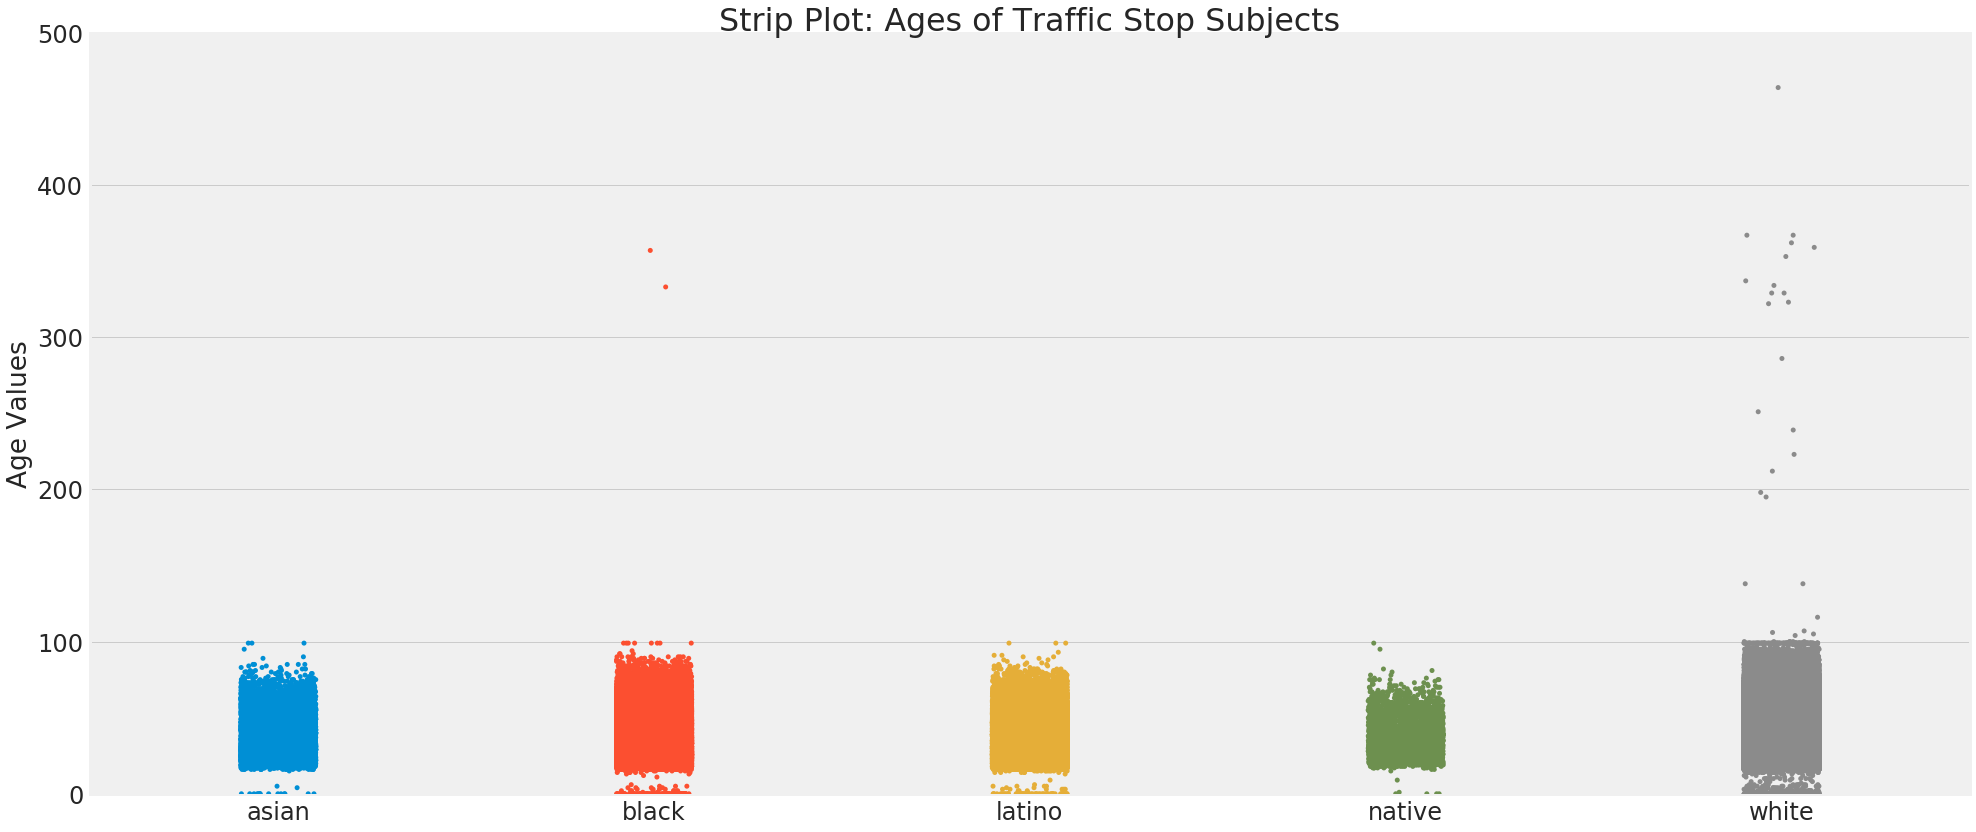

In [106]:
sns.stripplot(x="race", y="age", data=stop, jitter=True)
plt.xlabel('')
plt.ylabel('Age Values')
plt.ylim(0, 500)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('Strip Plot: Ages of Traffic Stop Subjects')
plt.show()

In [107]:
# Ensure data type is float to allow for further manipulation
stop['age'] = stop['age'].astype(float)

In [108]:
# Set extremely low or high ages to the mean value
stop['age'] = [stop['age'].mean() if age > 100 or age < 10 else age for age in stop['age']]

#### Note the Skewed Distribution of Ages
A log transformation was applied to the subject ages in order to normalize their distribution (see right):

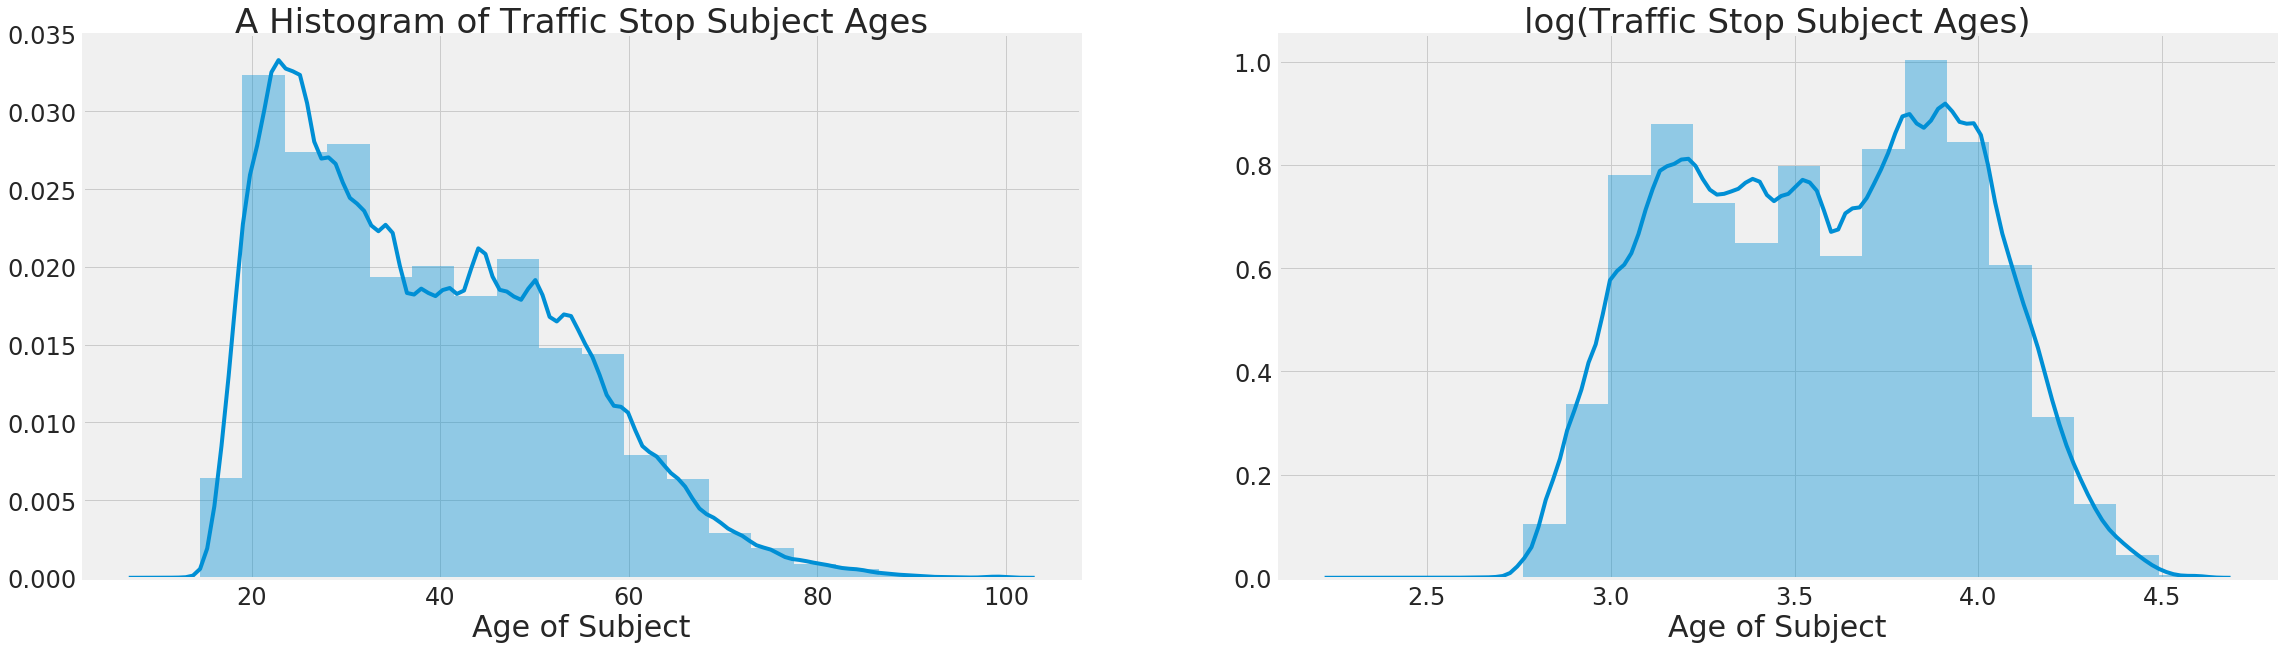

In [109]:
plt.rcParams['figure.figsize'] = (35.0, 10.0)
plt.subplot(1,2,1)
sns.distplot(stop['age'], bins=20, kde_kws={"lw": 4})
plt.xlabel('Age of Subject', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('A Histogram of Traffic Stop Subject Ages', fontsize=34)
plt.subplot(1,2,2)
sns.distplot(np.log(stop['age']), bins=20, kde_kws={"lw": 4})
plt.xlabel('Age of Subject', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('log(Traffic Stop Subject Ages)', fontsize=34);

### Reason for Traffic Stop
The majority of stops for all races are for what are defined as being for Vehicle reasons. This denotes the way in which the vehicle was being operated, and can include things such as speeding, careless driving, DWI and many others. This is distinct from Equipment-related causes, which concern the actual condition of the vehicle. Stops can also be categorized as Investigative. This means that the stop was conducted either in response to a specific alert, or due to suspicious behavior on the part of the operator.

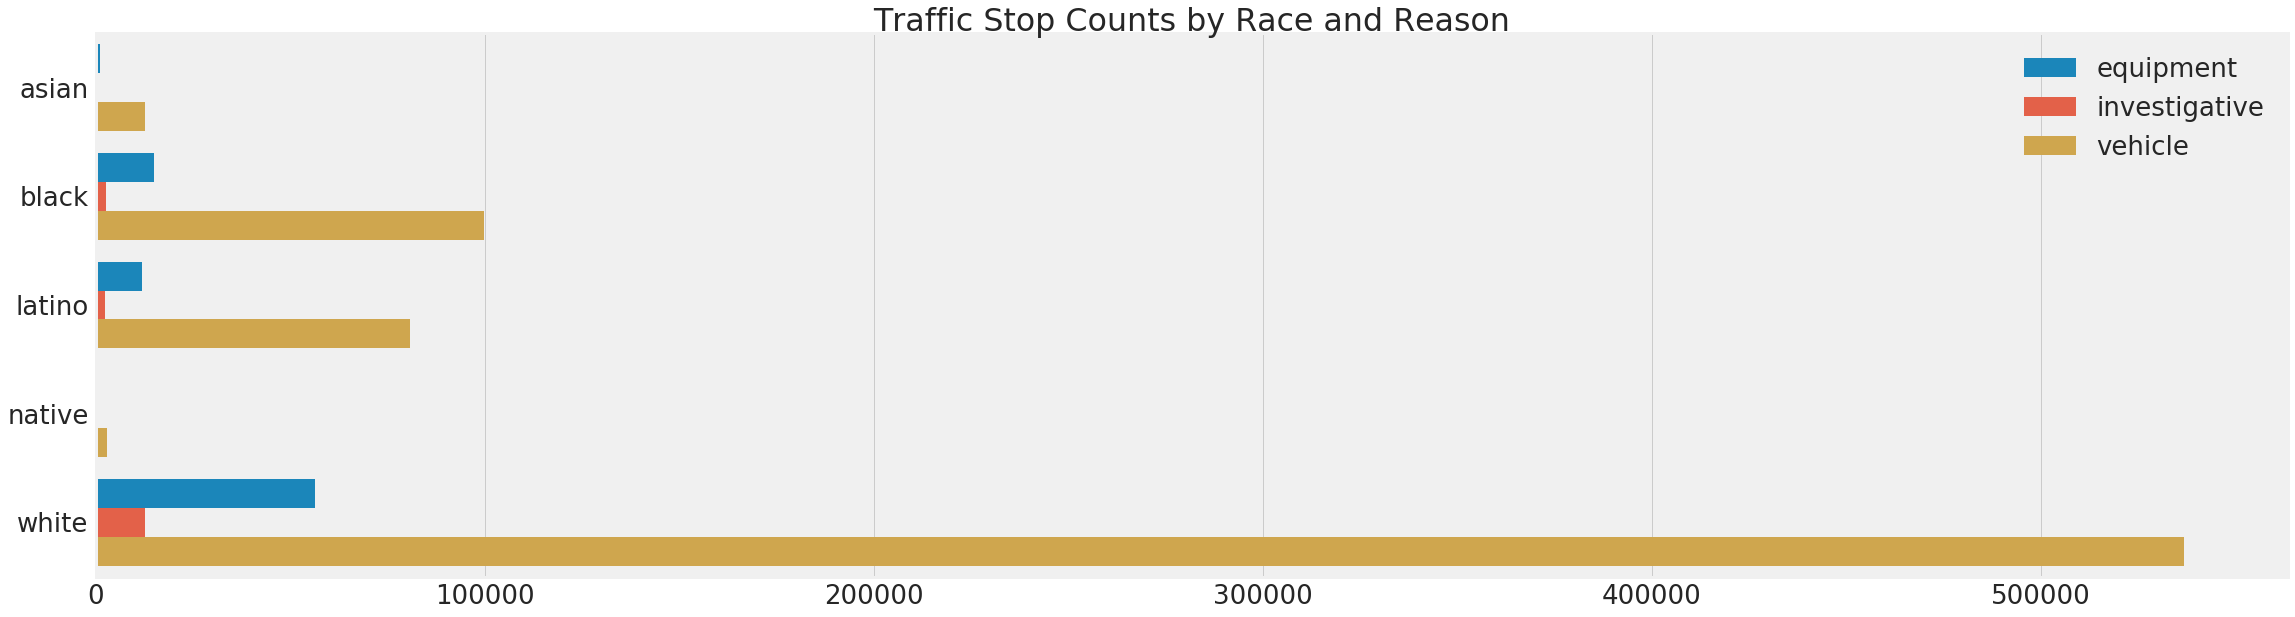

In [110]:
sns.countplot(y='race', hue='reason', data=stop)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(fontsize=26)
plt.xlabel('')
plt.ylabel('')
plt.title('Traffic Stop Counts by Race and Reason');

### Negative Outcomes and the Ages of Subjects
With regard to three particular negative outcomes of the stop, we find that, in most cases regardless of race of the subject, those searched, found to be in possession of contraband, and/or arrested, are mostly younger motorists. This only fails to be true when considering Native Americans who are arrested as a result of the traffic stop.

In [111]:
def violin(xval, yval, hueval, df, titleval):
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    sns.violinplot(xval, yval, hue=hueval, data=df)
    locval = 9
    plt.title(titleval)
    plt.ylim(0, 120)

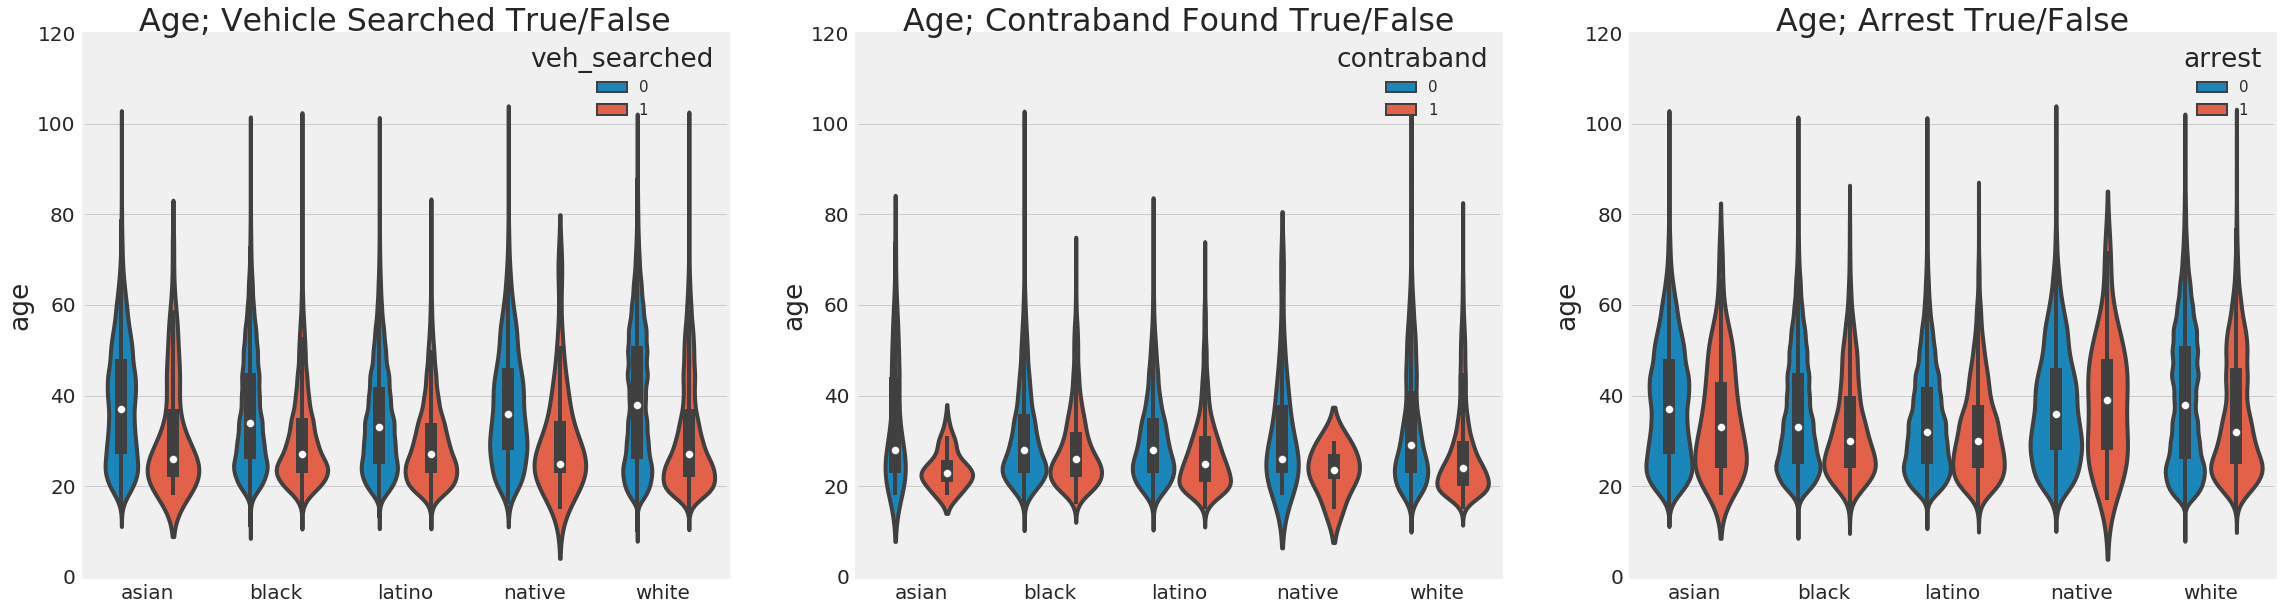

In [112]:
info = {'dfs': [stop, stop[stop['veh_searched'] == True], stop],
        'hues': ['veh_searched', 'contraband', 'arrest'],
        'titles': ['Age; Vehicle Searched True/False',
                'Age; Contraband Found True/False',
                'Age; Arrest True/False']}
for i in range(1,4):
        plt.subplot(1,3,i)
        violin('race', 'age', info['hues'][i-1], info['dfs'][i-1], info['titles'][i-1])
        plt.xlabel('')
        plt.title(info['titles'][i-1])

### Officer Stop Volume
We see here that the a large number of officers made only a single traffic stop. At the upper end of the scale, there are officers who made over 3000 stops in the two-year period. 

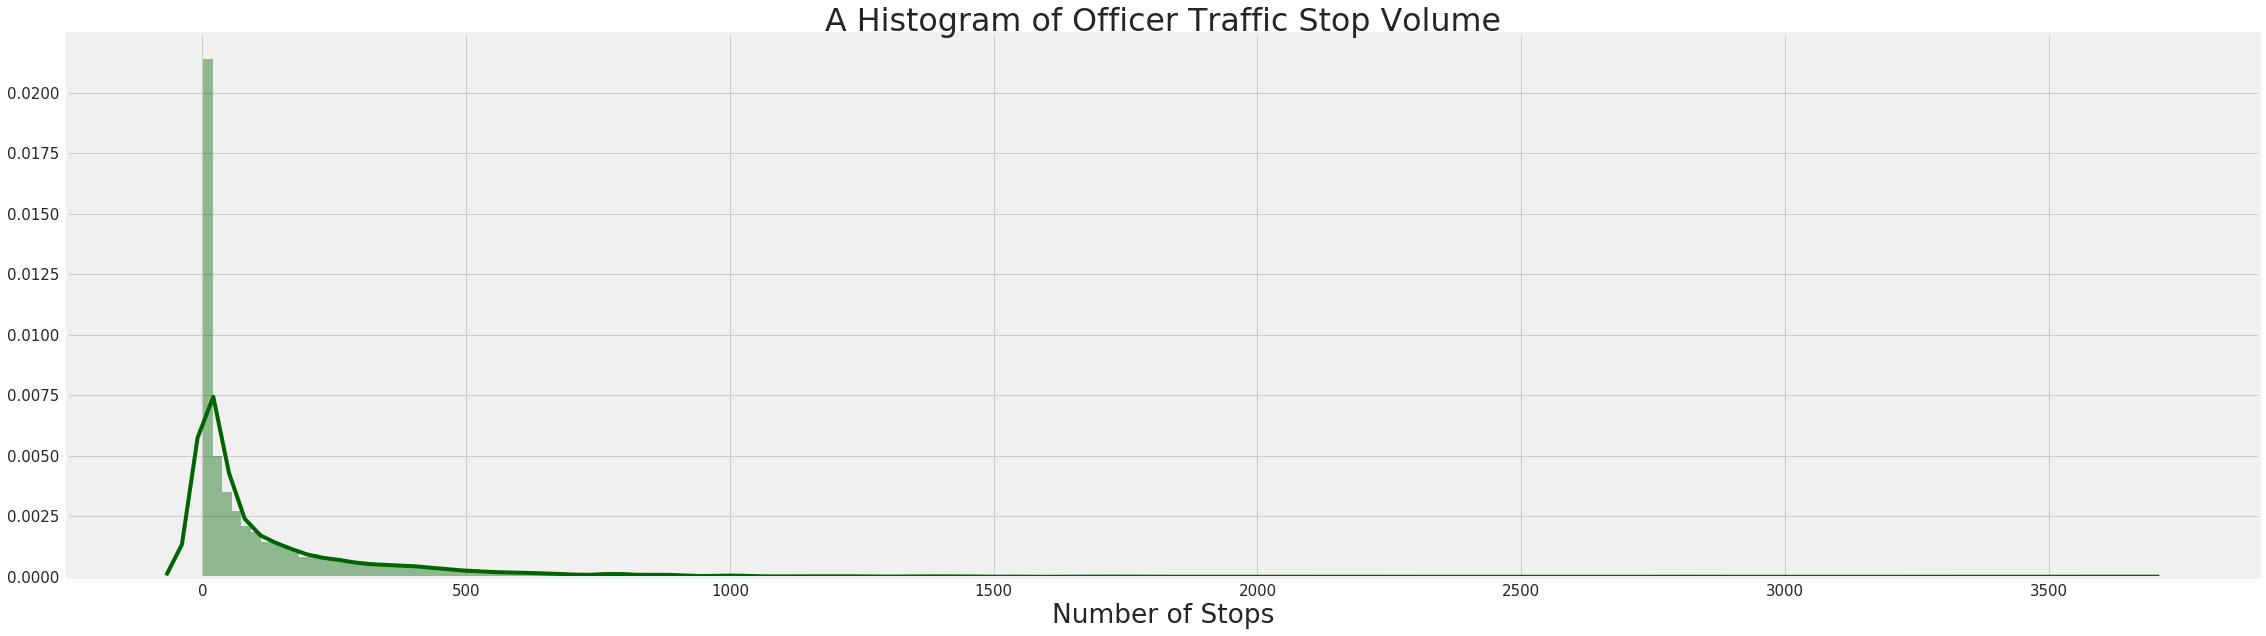

In [113]:
sns.distplot(stop['officer'].value_counts(), bins=200, color='darkgreen')
plt.xlabel('Number of Stops')
plt.title('A Histogram of Officer Traffic Stop Volume');

## Comparing the Races in Depth

From the charts below, we see a few notable things, some of which we will look further into in the next section. First, black and latino subjects are considerably more likely to be pulled over for investigative reasons. What is not known is whether these higher stop rates were in response to Be on the Lookout (BOLO) alerts, or due to suspicious behavior on the part of the drivers. We also note that black and latino drivers are much more likely to have their vehicles searched during the course of the stop. Lastly, black and latino road users are more likely to be found with contraband. However, the t-tests in the next section will indicate that this is only due to the much higher search rates for black and latino motorists.

In [114]:
stop_black = stop[stop['race'] == 'black']
stop_white = stop[stop['race'] == 'white']
stop_latino = stop[stop['race'] == 'latino']
stop_asian = stop[stop['race'] == 'asian']
stop_native = stop[stop['race'] == 'native']

In [115]:
columns = ['reason', 'veh_searched', 'contraband', 'disposition']
categ_names = {'reason':[['Motor Vehicle', 'Investigative', 'Equipment'], 'Reason for Stop'],
              'veh_searched':[['No', 'Yes'], 'Vehicle Searched'],
              'contraband':[['No', 'Yes'], 'Contraband Found'],
              'disposition':[['Infraction', 'Verbal Warning', 'No Disposition', 'Written Warning', 
                             'Misdemeanor Summons', 'Uniform Arrest Report'], 'Outcome of Stop']
              }

White Subjects :



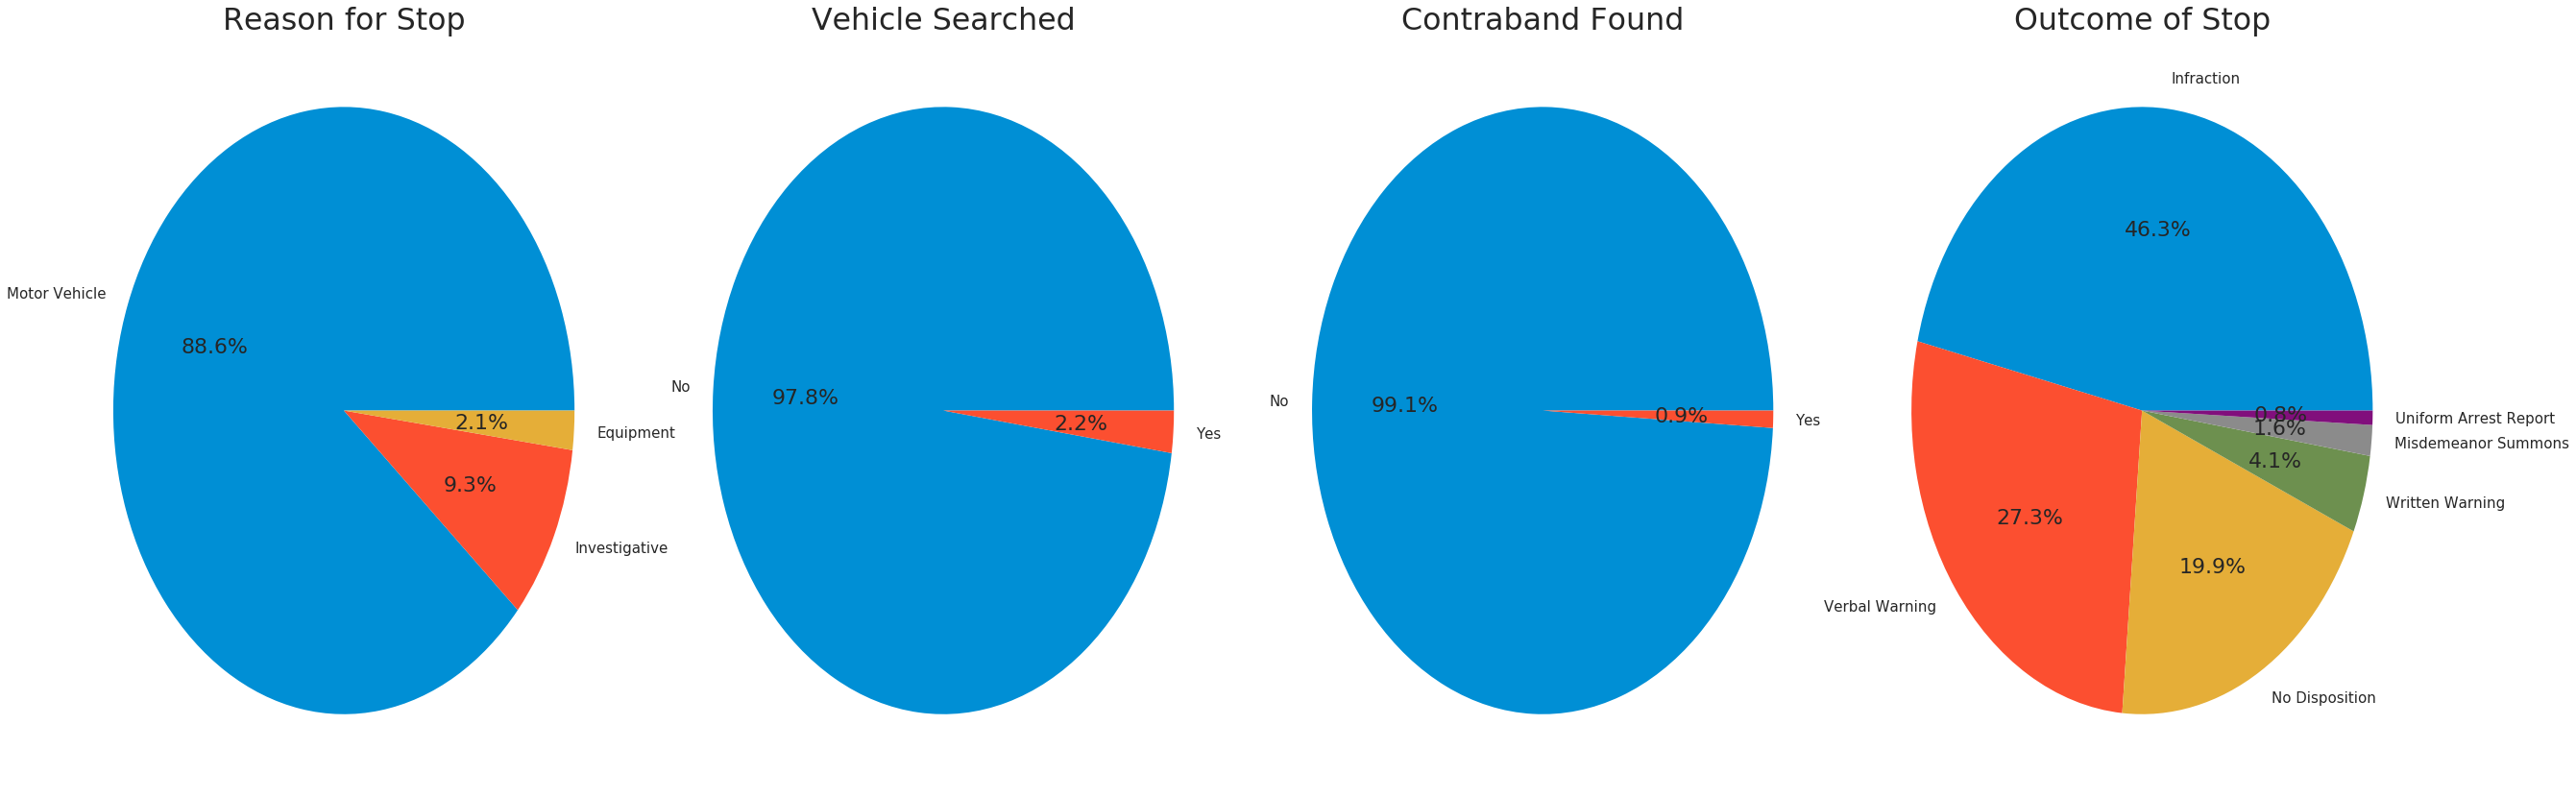

Black Subjects :



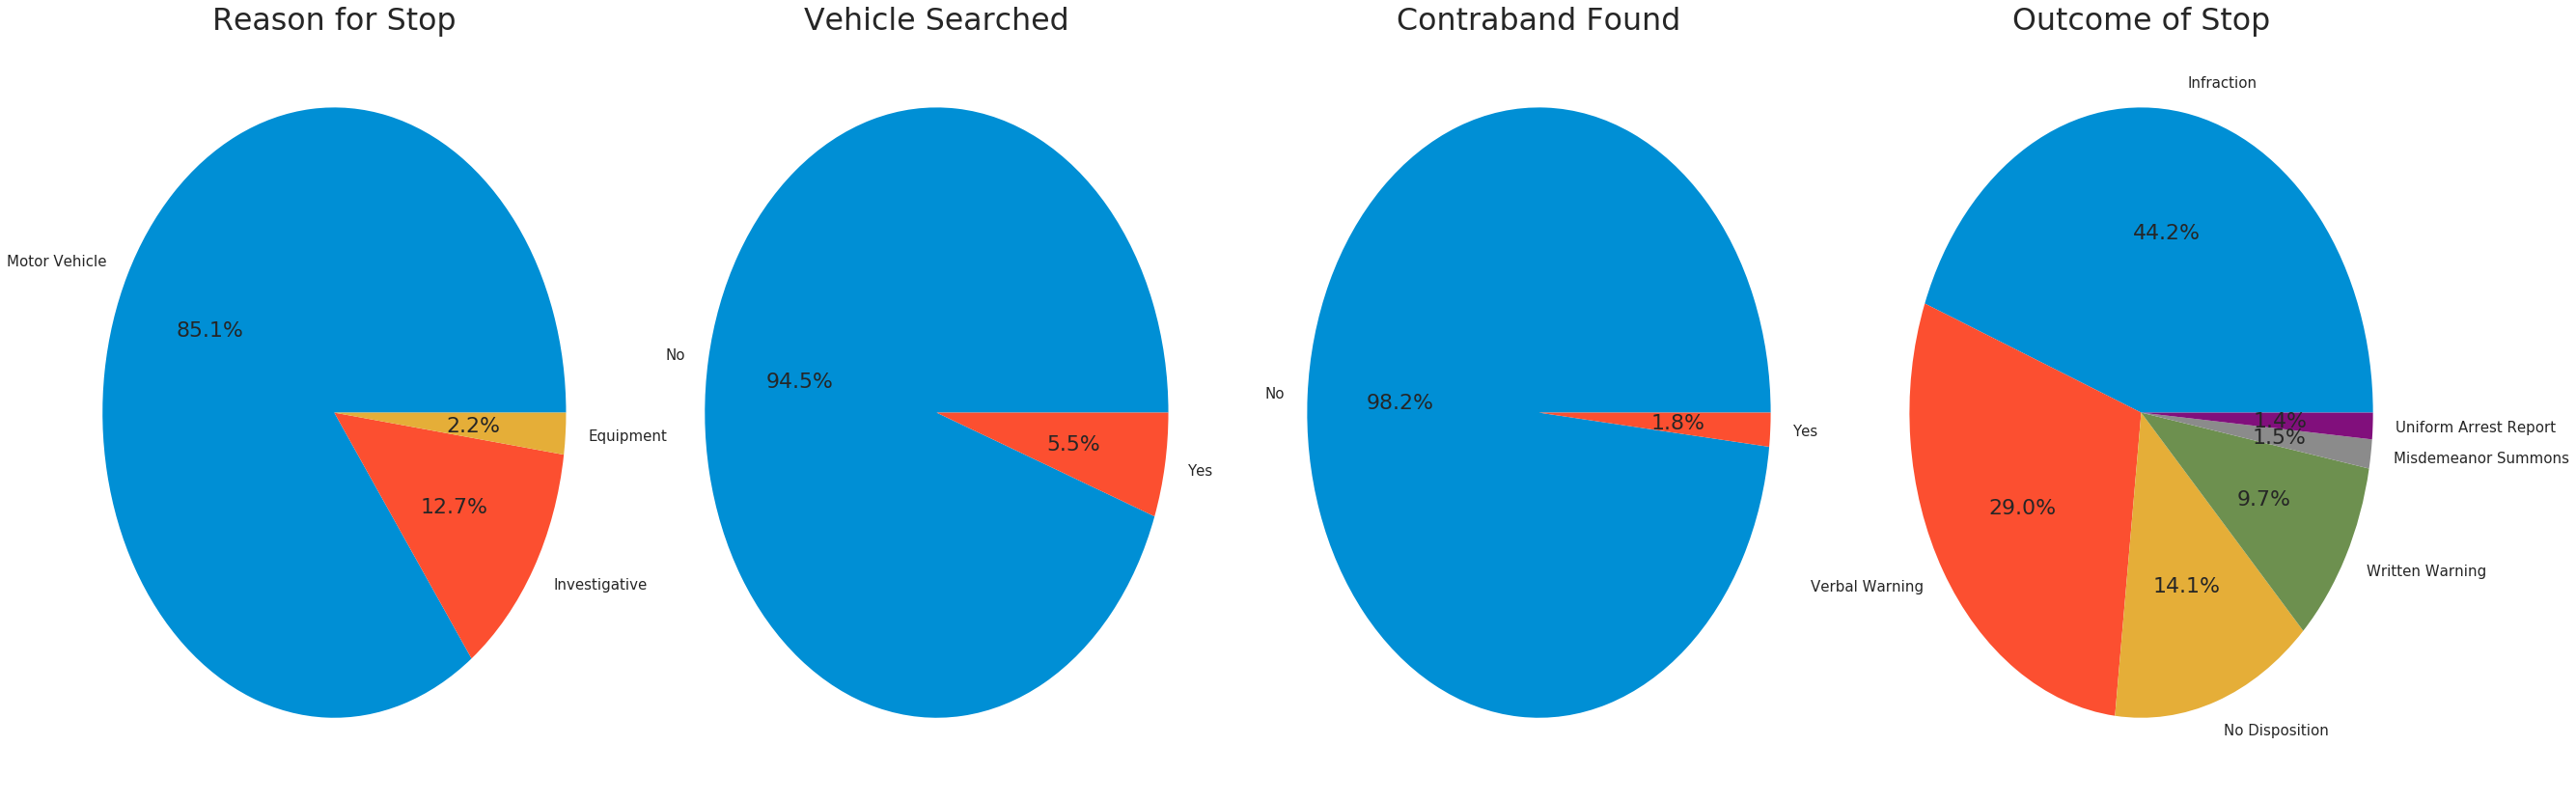

Latino Subjects :



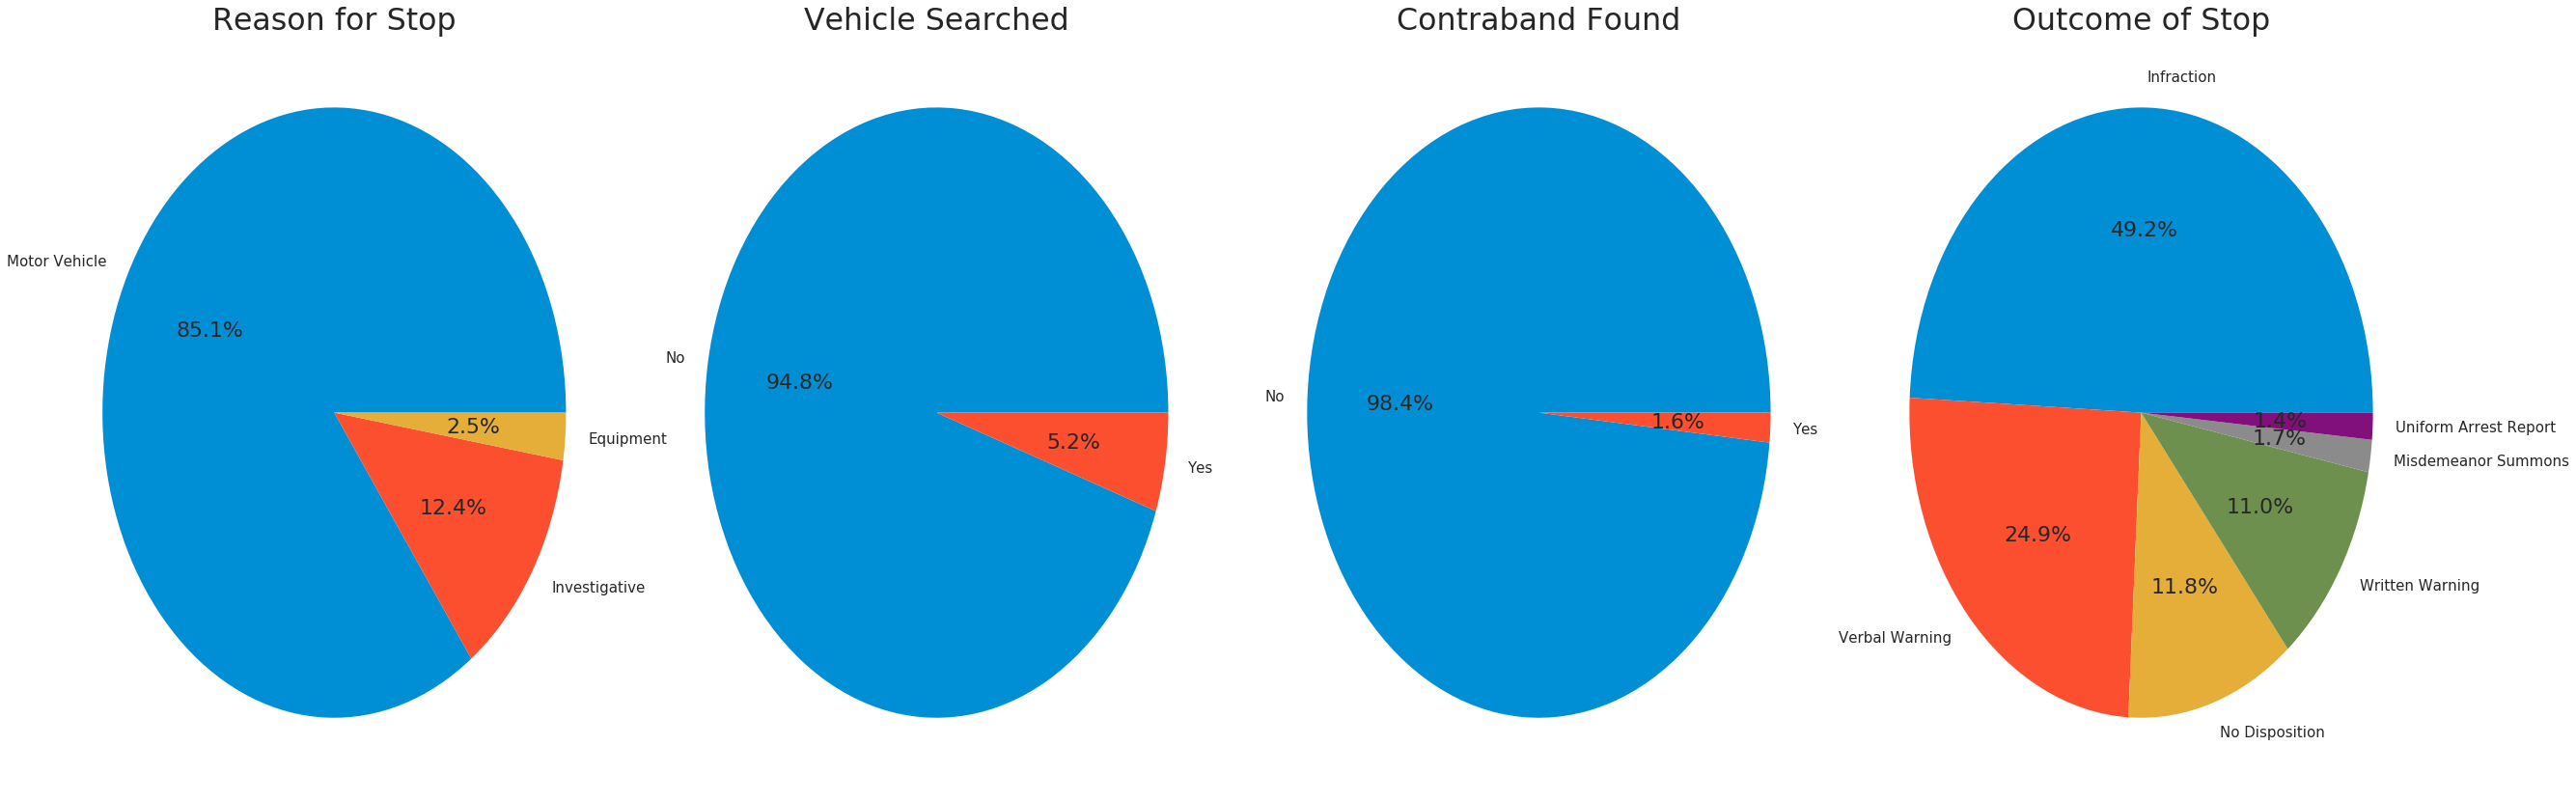

Asian Subjects :



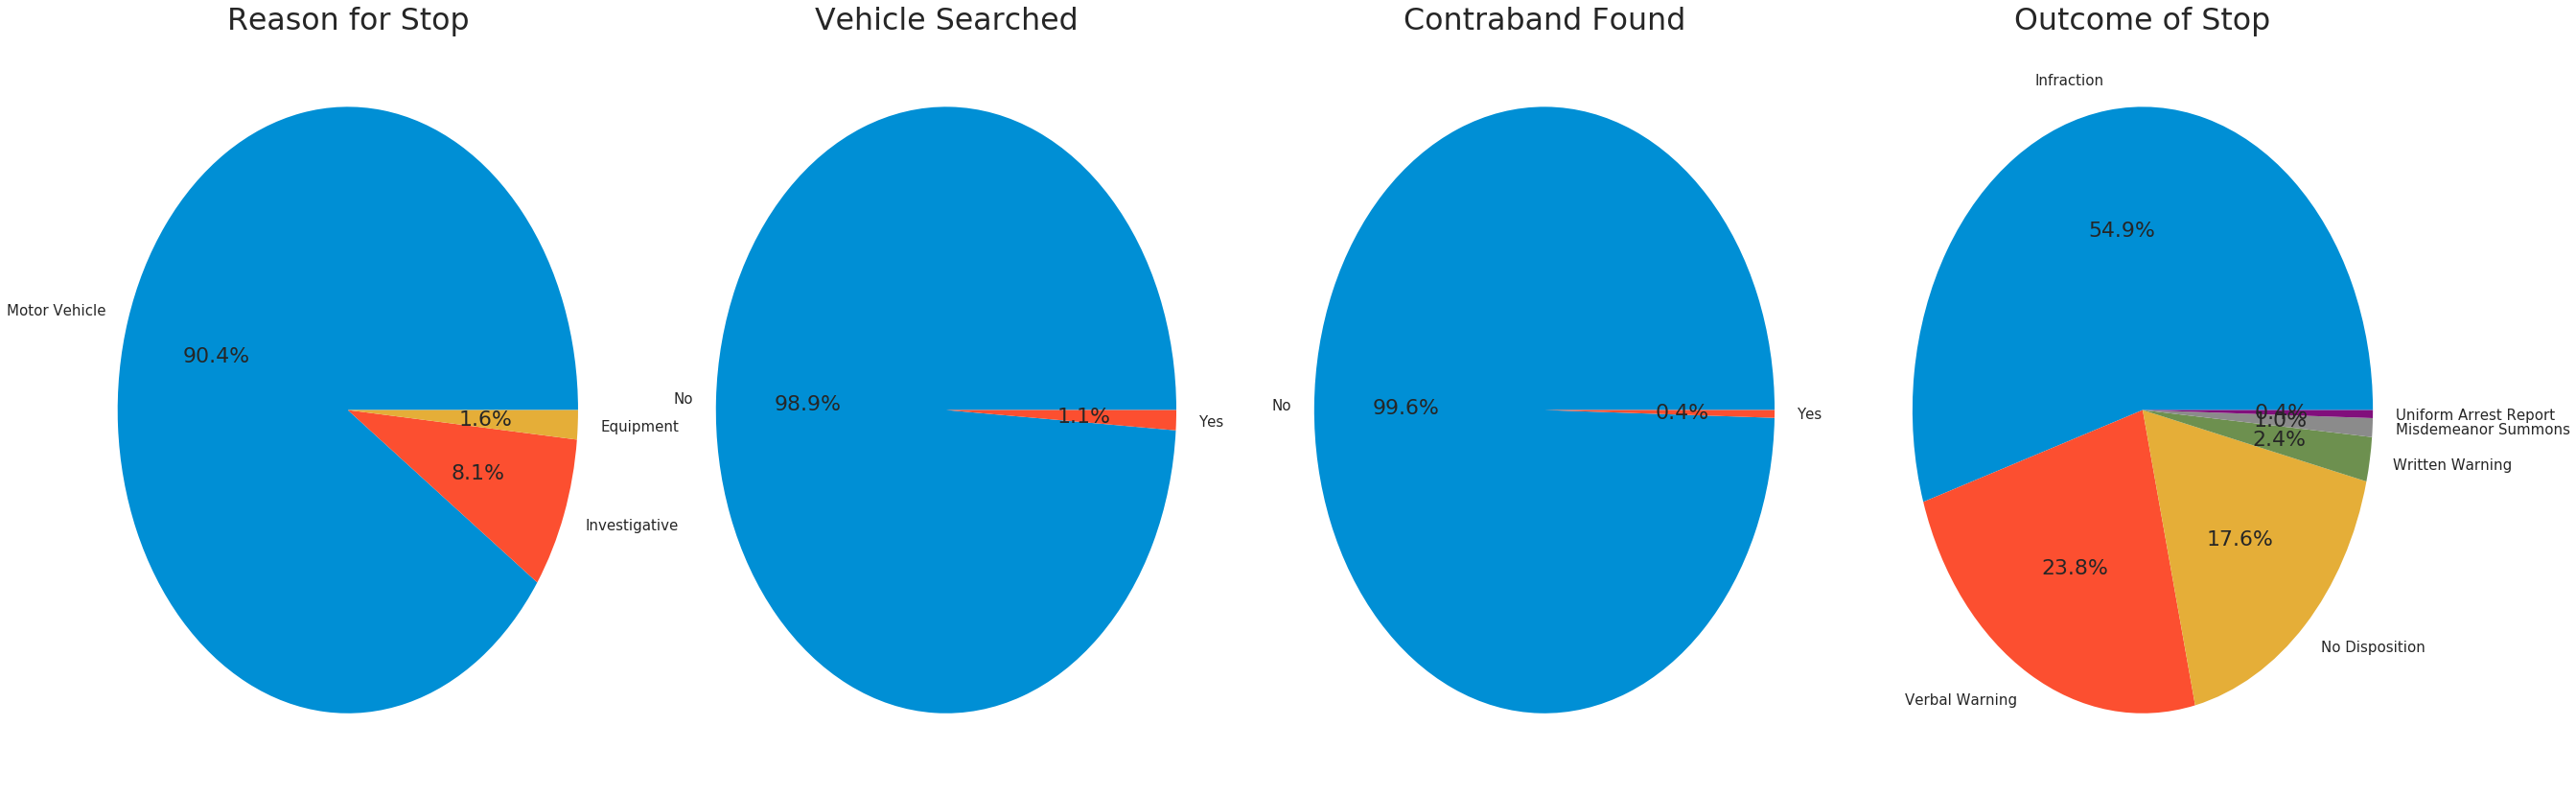

Native American Subjects :



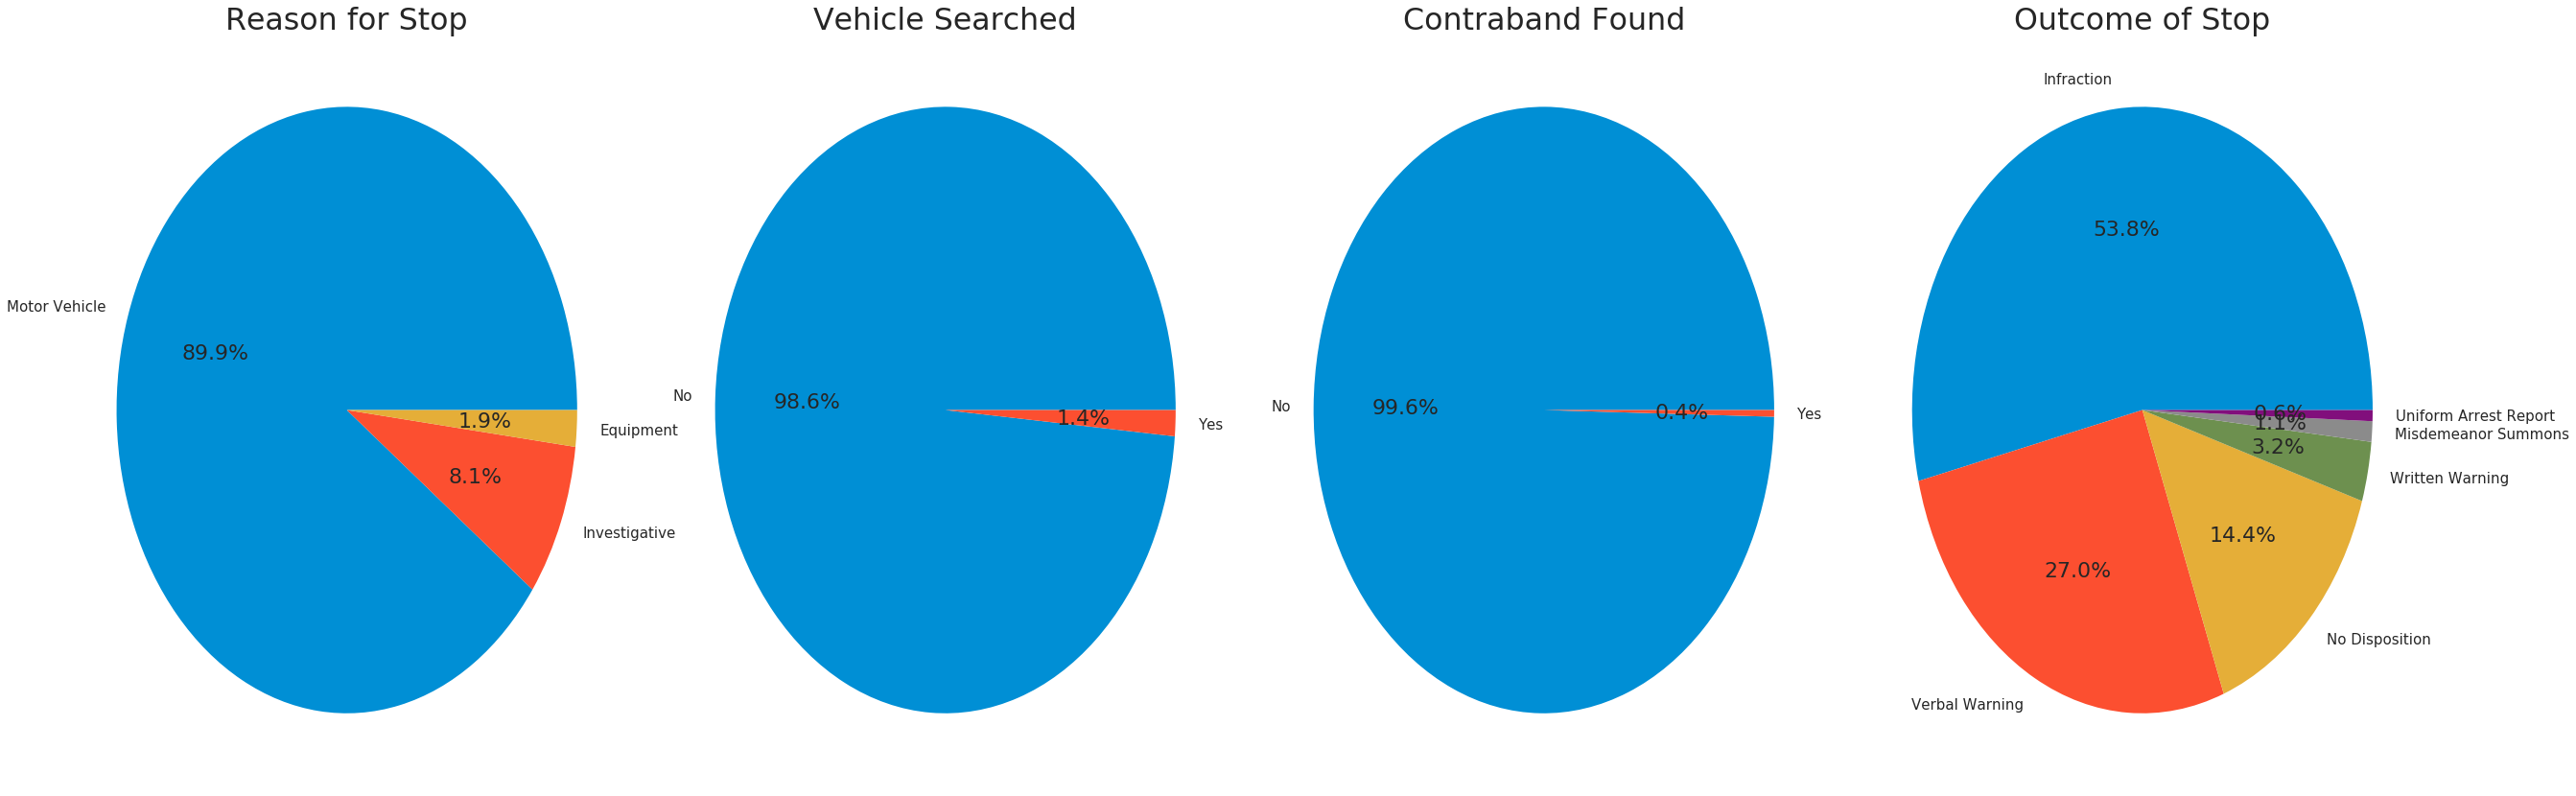

In [116]:
plt.rcParams['figure.figsize'] = (35.0, 12.0)
dfs = [stop_white, stop_black, stop_latino, stop_asian, stop_native]
captions = ['White Subjects', 'Black Subjects', 'Latino Subjects', 'Asian Subjects', 'Native American Subjects']
for i in range(0, len(dfs)):
    print(captions[i], ':\n')
    for j in range(0, len(columns)):
        plt.subplot(1, 4, j + 1)
        pie_chart(dfs[i], columns[j], categ_names[columns[j]][0], categ_names[columns[j]][1])
    plt.tight_layout()    
    plt.show()

<div class="alert alert-block alert-info"> 

Hypothesis 1:

Racial bias plays a role in at least some aspects of some interactions on the road between police and motorists.
</div>

### t-Testing

Here we run t-tests on individual demographic groups, to determine the statistical significance of trends found in the data.

#### Searches that took place during stops for non-investigative purposes

Supposing that a stop occurred due to the motorist's erratic driving, or due to a broken tail light. In theory, one might expect that such a stop would not normally result in a search of the vehicle. We look at the incidence of stops leading to searches, and determine whether the likelihood of this happening is higher for certain groups than for others. <br/> <br/>We find the following: <br/><br/>
Black males and Latino males are more likely than average, to a statistically significant degree, to have their car searched during a traffic stop whose original purpose was non-investigative. 

In [117]:
# t-test for people stopped for non-investigative purposes - were they subsequently searched or not:
black_m_search = stop[(stop['sex'] == 'male') & (stop['race'] == 'black') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
white_m_search = stop[(stop['sex'] == 'male') & (stop['race'] == 'white') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
latino_m_search = stop[(stop['sex'] == 'male') & (stop['race'] == 'latino') & 
                       (stop['reason'] != 'investigative')]['veh_searched']
asian_m_search = stop[(stop['sex'] == 'male') & (stop['race'] == 'asian') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
native_m_search = stop[(stop['sex'] == 'male') & (stop['race'] == 'native') & 
                       (stop['reason'] != 'investigative')]['veh_searched']
black_f_search = stop[(stop['sex'] == 'female') & (stop['race'] == 'black') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
white_f_search = stop[(stop['sex'] == 'female') & (stop['race'] == 'white') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
latino_f_search = stop[(stop['sex'] == 'female') & (stop['race'] == 'latino') & 
                       (stop['reason'] != 'investigative')]['veh_searched']
asian_f_search = stop[(stop['sex'] == 'female') & (stop['race'] == 'asian') & 
                      (stop['reason'] != 'investigative')]['veh_searched']
native_f_search = stop[(stop['sex'] == 'female') & (stop['race'] == 'native') & 
                       (stop['reason'] != 'investigative')]['veh_searched']

stop_search = [black_m_search, white_m_search, latino_m_search, asian_m_search, native_m_search, 
               black_f_search, white_f_search, latino_f_search, asian_f_search, native_f_search]
names = ['black_m', 'white_m', 'latino_m', 'asian_m', 'native_m', 'black_f', 'white_f', 'latino_f', 
         'asian_f', 'native_f']

print('Overall Population Mean:', mean(stop[stop['statute_reason'] != 'investigative']['veh_searched']))
print('-' * 80)
for i in range(0, len(stop_search)):
    t = ttest_ind(stop_search[i], stop[stop['statute_reason'] != 'investigative']['veh_searched'], 
                  equal_var=False)
    p_value = t[1]
    if p_value < 0.05:
            print(names[i], 'mean = ', mean(stop_search[i]), ':', t)           

Overall Population Mean: 0.030170835656529157
--------------------------------------------------------------------------------
black_m mean =  0.06959803636939481 : Ttest_indResult(statistic=41.803416392237494, pvalue=0.0)
white_m mean =  0.02689823063009153 : Ttest_indResult(statistic=-10.04197382110285, pvalue=1.0000965222343373e-23)
latino_m mean =  0.06159392260919345 : Ttest_indResult(statistic=32.596392367981494, pvalue=2.5479956080547237e-231)
asian_m mean =  0.0120928205686894 : Ttest_indResult(statistic=-15.636499048811007, pvalue=1.898774098380564e-54)
native_m mean =  0.014452027298273785 : Ttest_indResult(statistic=-6.5522584889631847, pvalue=6.8472155387961673e-11)
black_f mean =  0.01994827277150393 : Ttest_indResult(statistic=-13.967399731625132, pvalue=3.0541137333679828e-44)
white_f mean =  0.012011532490574408 : Ttest_indResult(statistic=-61.337626503593896, pvalue=0.0)
latino_f mean =  0.023522294580264048 : Ttest_indResult(statistic=-7.2011446494334193, pvalue=6.108

#### The likelihood of contraband being found in searches during non-investigative stops 

Given that a search has taken place, we next look at the frequency with which contraband is found. <br/><br/>
Here we find: <br/>
-  Black males are less likely than average to be found to be in possession of contraband, as a result of these non-investigative searches.
-  White males are more likely than average to be found to be in possession of contraband, as a result of these non-investigative searches.

Thus the higher likelihood of a search among black and latino motorists is accompanied by a lower than average success rate when it comes to actually finding contraband. 

In [118]:
# Test for people who were stopped for non-investigative reason and subsequently searched 
# - was contraband found or not:
black_m_search_c = stop[(stop['sex'] == 'male') & (stop['race'] == 'black') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
white_m_search_c = stop[(stop['sex'] == 'male') & (stop['race'] == 'white') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
latino_m_search_c = stop[(stop['sex'] == 'male') & (stop['race'] == 'latino') & 
                         (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
asian_m_search_c = stop[(stop['sex'] == 'male') & (stop['race'] == 'asian') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
native_m_search_c = stop[(stop['sex'] == 'male') & (stop['race'] == 'native') & 
                         (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
black_f_search_c = stop[(stop['sex'] == 'female') & (stop['race'] == 'black') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
white_f_search_c = stop[(stop['sex'] == 'female') & (stop['race'] == 'white') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
latino_f_search_c = stop[(stop['sex'] == 'female') & (stop['race'] == 'latino') & 
                         (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
asian_f_search_c = stop[(stop['sex'] == 'female') & (stop['race'] == 'asian') & 
                        (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']
native_f_search_c = stop[(stop['sex'] == 'female') & (stop['race'] == 'native') & 
                         (stop['reason'] != 'investigative') & (stop['veh_searched'])]['contraband']

stop_search_c = [black_m_search_c, white_m_search_c, latino_m_search_c, asian_m_search_c, 
                 native_m_search_c, black_f_search_c, white_f_search_c, latino_f_search_c, 
                 asian_f_search_c, native_f_search_c]

print('Overall Population Mean:', mean(stop[(stop['statute_reason'] != 'investigative') & 
                                            (stop['veh_searched'])]['contraband']))
print('-' * 80)
for i in range(0, len(stop_search_c)):
    t = ttest_ind(stop_search_c[i], stop[(stop['statute_reason'] != 'investigative') & 
                                         (stop['veh_searched'])]['contraband'], equal_var=False)
    p_value = t[1]
    if p_value < 0.05:
            print(names[i], 'mean = ', mean(stop_search_c[i]), ':', t)    

Overall Population Mean: 0.31499841370558374
--------------------------------------------------------------------------------
black_m mean =  0.2720894956389837 : Ttest_indResult(statistic=-6.318480178567512, pvalue=2.7852678034145933e-10)
white_m mean =  0.3702093234907473 : Ttest_indResult(statistic=9.7391898852340013, pvalue=2.3390555844220018e-22)
latino_m mean =  0.24692288369756343 : Ttest_indResult(statistic=-9.1561100464550407, pvalue=7.4191372644946833e-20)
asian_m mean =  0.22522522522522523 : Ttest_indResult(statistic=-2.2479079131029005, pvalue=0.02655451092766702)
native_m mean =  0.1388888888888889 : Ttest_indResult(statistic=-3.0089183445668417, pvalue=0.0048224712523646188)
black_f mean =  0.21309370988446727 : Ttest_indResult(statistic=-6.8074190980683582, pvalue=1.8890487276731354e-11)
latino_f mean =  0.2405446293494705 : Ttest_indResult(statistic=-4.4075585313040673, pvalue=1.2091375063634877e-05)


In [119]:
# Using disposition column, define a binary outcome of traffic stop: 
# 0: A let-off. Warning of some kind, or no disposition
# 1: Some kind of punishment, up to and including arrest
disp_dict = {'infraction': 1, 'verbal_w': 0, 'written_w': 0, 'misdemeanor_summ': 1, 
             'no_disposition': 0, 'uniform_arrest': 1}

In [120]:
stop['disp_num'] = [disp_dict[dispo] for dispo in stop['disposition']]

#### Outcomes of stops due to defective lights

Here we look at cases where the motorist was stopped for an innocuous reason, such as defective lights. Removing those that resulted in arrest or misdemeanor summons, possibly due to outstanding warrants or prior violations, we want to see the intra-group distribution of punitive (where a ticket was issued) outcomes, vs. non-punitive ones, i.e. a warning or nothing.<br/> <br/>
Most notable among the findings:<br/> 
-  Latino males are much more likely than any other group to receive a punitive outcome for this particular offence.
-  White, asian and black females, in that order, are the least likely groups to receive a punitive outcome for this offence.

In [121]:
# Test for people who were stopped for innocuous fault - 
# were they disciplined (disp_num = 1) or not (disp_num = 0):
black_m_lights = stop[(stop['sex'] == 'male') & (stop['race'] == 'black') & 
                      (stop['statute_reason'] == 'Defective Lights') & 
                      (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
black_f_lights = stop[(stop['sex'] == 'female') & (stop['race'] == 'black') & 
                      (stop['statute_reason'] == 'Defective Lights') &
                     (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
white_m_lights = stop[(stop['sex'] == 'male') & (stop['race'] == 'white') & 
                      (stop['statute_reason'] == 'Defective Lights') &
                     (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
white_f_lights = stop[(stop['sex'] == 'female') & (stop['race'] == 'white') & 
                      (stop['statute_reason'] == 'Defective Lights') &
                     (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
latino_m_lights = stop[(stop['sex'] == 'male') & (stop['race'] == 'latino') & 
                       (stop['statute_reason'] == 'Defective Lights') &
                      (stop['disposition'] != 'uniform_arrest') & 
                       (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
latino_f_lights = stop[(stop['sex'] == 'female') & (stop['race'] == 'latino') & 
                       (stop['statute_reason'] == 'Defective Lights') &
                      (stop['disposition'] != 'uniform_arrest') & 
                       (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
asian_m_lights = stop[(stop['sex'] == 'male') & (stop['race'] == 'asian') & 
                      (stop['statute_reason'] == 'Defective Lights') &
                     (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
asian_f_lights = stop[(stop['sex'] == 'female') & (stop['race'] == 'asian') & 
                      (stop['statute_reason'] == 'Defective Lights') &
                     (stop['disposition'] != 'uniform_arrest') & 
                      (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
native_m_lights = stop[(stop['sex'] == 'male') & (stop['race'] == 'native') & 
                       (stop['statute_reason'] == 'Defective Lights') &
                      (stop['disposition'] != 'uniform_arrest') & 
                       (stop['disposition'] != 'misdemeanor_summ')]['disp_num']
native_f_lights = stop[(stop['sex'] == 'female') & (stop['race'] == 'native') & 
                       (stop['statute_reason'] == 'Defective Lights') &
                      (stop['disposition'] != 'uniform_arrest') & 
                       (stop['disposition'] != 'misdemeanor_summ')]['disp_num']

In [122]:
stop_lights = [black_m_lights, white_m_lights, latino_m_lights, asian_m_lights, native_m_lights, 
                 black_f_lights, white_f_lights, latino_f_lights, asian_f_lights, native_f_lights]
print('Overall Population Mean:', mean(stop[stop['statute_reason'] == 'Defective Lights']['disp_num']))
print('-' * 80)
for i in range(0, len(stop_lights)):
    t = ttest_ind(stop_lights[i], (stop[stop['statute_reason'] == 'Defective Lights']['disp_num']), 
                  equal_var=False)
    p_value = t[1]
    if p_value < 0.05:
            print(names[i], 'mean = ', mean(stop_lights[i]), ':', t)    

Overall Population Mean: 0.13845465584457084
--------------------------------------------------------------------------------
white_m mean =  0.09504106520657044 : Ttest_indResult(statistic=-21.182349549821097, pvalue=2.8550271210097363e-99)
latino_m mean =  0.2017690253671562 : Ttest_indResult(statistic=11.879037313915953, pvalue=3.2022023463635904e-32)
asian_m mean =  0.09963547995139732 : Ttest_indResult(statistic=-3.690228372077053, pvalue=0.00023840372690242236)
native_m mean =  0.09734513274336283 : Ttest_indResult(statistic=-2.0762018234112247, pvalue=0.03900237372010186)
black_f mean =  0.08814996652532917 : Ttest_indResult(statistic=-11.401542127471252, pvalue=9.147541319976263e-30)
white_f mean =  0.0664508094645081 : Ttest_indResult(statistic=-33.517214077613019, pvalue=4.2971997678070323e-243)
asian_f mean =  0.08083140877598152 : Ttest_indResult(statistic=-4.3745695301033178, pvalue=1.521105855418377e-05)


<div class="alert alert-block alert-info">
Hypothesis 2:
The outcome of interactions between police and motorists can be statistically modeled and predicted as a function of demographic factors, specifically race.
</div>

In this next section, we run statistical models in order to be able to model the outcome of a traffic stop based on certain known input attributes. For this part of the analysis, any attributes that clearly relate to the outcome are removed, since those are what we are trying to model using other attributes.

In [123]:
# Isolate the categorical variables in the dataframe
categorical = stop.select_dtypes(include=['category'])
categorical.head()

,dept,officer,month,race,eth,sex,location,reason,technique,statute_reason,auth_search,disposition
0,Branford,378,October,white,non-hispanic,female,branford,vehicle,G,Seatbelt,N,verbal_w
1,State Police,1000001940,October,white,middle-east,male,new haven,vehicle,G,Other,N,verbal_w
2,State Police,1000002349,October,latino,hispanic,female,norwich,vehicle,G,Seatbelt,N,infraction
3,State Police,987312802,October,black,non-hispanic,male,old saybrook,vehicle,G,Other,N,infraction
4,Branford,1051,October,white,non-hispanic,male,branford,investigative,G,Display of Plates,N,no_disposition


In [124]:
# Next isolate the numerical variables
numerical = stop.drop(categorical.columns, axis=1)
numerical.head()

,age,res,town_res,duration,towed,veh_searched,contraband,arrest,hour,monthday,weekday,disp_num
0,36.0,1,0,1.0,0,0,0,0,12,1,1,0
1,46.0,1,1,1.0,0,0,0,0,14,1,1,0
2,33.0,1,0,1.0,1,0,0,0,20,1,1,1
3,64.0,1,0,1.0,0,0,0,0,2,1,1,1
4,49.0,1,1,1.0,0,0,0,0,9,1,1,0


In [125]:
# Apply log transformation to subject age as we will start to model on it from here on
numerical['age'] = np.log(numerical['age'])

In [126]:
# Scale all numerical variables
scaler = StandardScaler()
numerical_scaled = pd.DataFrame(scaler.fit_transform(numerical), columns=numerical.columns)
# Re-state disp_num which should be a binary column
numerical_scaled['disp_num'] = numerical['disp_num']
# Check the scaled table of numerical features
numerical_scaled.head()

,age,res,town_res,duration,towed,veh_searched,contraband,arrest,hour,monthday,weekday,disp_num
0,0.018256,0.377769,-0.645044,-0.328596,-0.252001,-0.176379,-0.105518,-0.145411,-0.065520,-1.708757,-1.015128,0.0
1,0.655014,0.377769,1.550283,-0.328596,-0.252001,-0.176379,-0.105518,-0.145411,0.231246,-1.708757,-1.015128,0.0
2,-0.207774,0.377769,-0.645044,-0.328596,3.968244,-0.176379,-0.105518,-0.145411,1.121545,-1.708757,-1.015128,1.0
3,1.512887,0.377769,-0.645044,-0.328596,-0.252001,-0.176379,-0.105518,-0.145411,-1.549351,-1.708757,-1.015128,1.0
4,0.819134,0.377769,1.550283,-0.328596,-0.252001,-0.176379,-0.105518,-0.145411,-0.510669,-1.708757,-1.015128,0.0


In [127]:
# Put the two dataframes back together after scaling the numerical variables
stop_scaled = pd.concat([categorical, numerical_scaled], axis=1)

In [128]:
stop_scaled.dropna(inplace=True)

In [129]:
stop_scaled.reset_index(inplace=True)

In [130]:
# Shape of the final dataset, ready to model
stop_scaled.shape

(817091, 25)

### Create a Random Sample of the Dataset
Due to the large size of the dataset, it was necessary to run the models on a small sample, compare the results from these, and select one or two 'finalists' from these. The chosen model(s) was then to be run on a larger sample of the entire dataset.

In [131]:
# Define reduced dataframe, specifying fraction of total data to be used
stop_samp = stop_scaled.sample(frac=0.1)
len(stop_samp)

81709

In [132]:
# Define dummy table for regression analysis
start_time = time.time()
stop_dummies = pd.get_dummies(stop_samp)
print(stop_dummies.shape)
t = time.time() - start_time
print('Time taken:', '%.1f' % (t / 60), 'minutes.')

(81709, 6368)
Time taken: 0.1 minutes.


In [133]:
start_time = time.time()
corrmat = stop_dummies.corr()
t = time.time() - start_time
print('Time taken:', '%.1f' % (t / 60), 'minutes.')

Time taken: 149.4 minutes.


In [134]:
corrmat.head()

,index,age,res,town_res,duration,towed,veh_searched,contraband,arrest,hour,...,auth_search_C,auth_search_I,auth_search_N,auth_search_O,disposition_infraction,disposition_misdemeanor_summ,disposition_no_disposition,disposition_uniform_arrest,disposition_verbal_w,disposition_written_w
index,1.000000,0.009781,0.011843,-0.042439,-0.010268,-0.013368,0.004456,0.002393,0.002576,0.035298,...,0.000724,-0.000352,0.004460,-0.006232,-0.022566,-0.003759,0.000125,0.003484,0.026182,0.000276
age,0.009781,1.000000,-0.015966,0.003835,-0.075745,-0.039316,-0.098629,-0.072920,-0.034163,0.006713,...,0.000650,0.005734,-0.000283,-0.003124,0.000388,-0.006853,0.007535,-0.001325,0.001897,-0.000694
res,0.011843,-0.015966,1.000000,0.224324,0.031354,0.049192,0.030041,0.020244,0.018700,0.007857,...,-0.002878,0.003951,0.001210,-0.001630,0.001292,0.001211,0.000329,-0.004402,-0.000256,-0.001101
town_res,-0.042439,0.003835,0.224324,1.000000,0.019425,0.019372,0.025511,0.015731,0.024777,0.014052,...,-0.000110,0.002586,-0.002546,0.002078,-0.005463,0.002912,0.002184,0.001583,-0.000683,0.005050
duration,-0.010268,-0.075745,0.031354,0.019425,1.000000,0.540103,0.367300,0.249462,0.335195,-0.026403,...,-0.001193,0.003657,0.002963,-0.004999,-0.004154,-0.002447,0.002893,0.000712,-0.001982,0.008040


In [135]:
corrmat['disp_num'].sort_values(ascending=True).isnull().sum()

1636

In [136]:
corr_disp=corrmat['disp_num'].sort_values(ascending=False)

In [137]:
corr_disp = corr_disp.dropna()

In [138]:
# Determine the features that have the highest +ve correlation with the 
# outcome variable (disp_num). Name this set of features 'top_vals'
# Set n, the number of features to use
n = 50
top_vals = [corr_disp.index[i] for i in range(0, len(corr_disp)) if not 'disp' in corr_disp.index[i]][0:n]

In [139]:
# Define bottom_vals as the n values having the highest NEGATIVE correlation
# against the target variable.
bottom_vals = [corr_disp.index[i] for i in range(0, len(corr_disp)) if not 'disp' in 
               corr_disp.index[i]][:-(n+1):-1]

In [140]:
top_plus_bottom = top_vals + bottom_vals

### Check for Co-Linearity
The 100 individual variable names (top_vals and bottom_vals) are too small to show here. However, the heatmap shows that, for the most part, the variables in this chosen set of 100 do not correlate with one another either positively or negatively. 

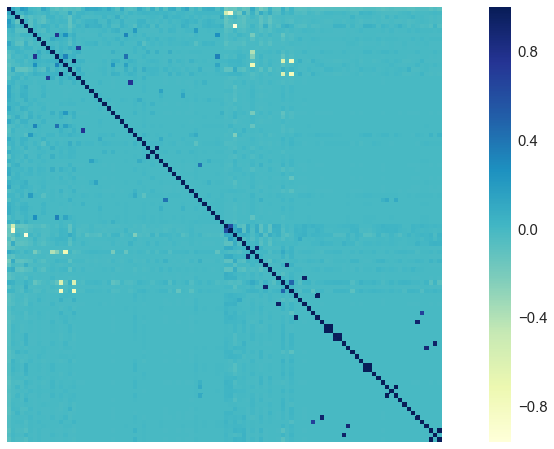

In [141]:
# Check that chosen variables don't correlate too much with one another
# Uncomment below depending on which combination of correlators you're using

#corr_chosen = corrmat.loc[top_vals, top_vals]
corr_chosen = corrmat.loc[top_plus_bottom,top_plus_bottom]
f, ax = plt.subplots(figsize=(15,8))
sns.set(font_scale=1.5) 
sns.heatmap(corr_chosen, vmax=1.0, cmap='YlGnBu', square=True, xticklabels=False, yticklabels=False)
plt.show()

In [142]:
# If using ALL available variables:

# Remove columns pertaining to 'disp' since that is what is being modeled:

#cols_to_drop = [col for col in stop_dummies.columns if 'disp' in col]
#X = stop_dummies.drop(cols_to_drop, axis=1)

# OR:

# If using only SOME variables:
X = stop_dummies[top_plus_bottom]

Y = pd.DataFrame(stop_samp['disp_num'])
Y=Y.astype('int')

In [143]:
X.head()

,dept_State Police,reason_vehicle,statute_reason_Registration,statute_reason_Other,technique_B,statute_reason_Seatbelt,location_hartford,statute_reason_Suspended License,statute_reason_Other/Error,location_danbury,...,dept_New Canaan,dept_Madison,dept_Cheshire,dept_Groton Town,location_naugatuck,location_willimantic,location_terryville,dept_Bloomfield,location_seymour,location_bloomfield
122205,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
590400,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
544046,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397055,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540363,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
# Reset X and Y indices, and remove 'index' column that appears:
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
if 'index' in X.columns:
    X.drop('index', axis=1, inplace=True)

In [145]:
X.shape

(81709, 100)

## Modeling

The following cells show a number of supervised learning runs using various models. In this analysis the target variable was the stop['disp_num'] variable defined earlier: the outcome of the traffic stop, whether punitive (arrest, summons, ticket) or non-punitive (verbal or written warning, or no warning). Each of these models was run using various combinations of input variables, and on varying samples of the dataset, from 1% of the data to 100%. Also, the input feature set (see 'top_vals' and 'bottom_vals' code above) was varied to see how that would affect the results.

### KNN Classifier

In [146]:
# This function runs the KNN Classifier
# and performs cross-validation
def knn_and_crossval(input_df, target, no_folds):
    start_time = time.time()
    knn_class = KNeighborsClassifier(n_neighbors=250, weights='distance')
    cvs = cross_val_score(knn_class, input_df, np.array(target).ravel(), cv=no_folds)
    print(cvs)  
    print('-' * 50, '\n')
    print('Average Accuracy: {}'.format('%.5f' % cvs.mean()))
    print('SD of Accuracy: {}'.format('%.5f' % cvs.std()))
    print('-' * 50)
    print('Time taken: {} minutes. \n'.format('%.3f' % ((time.time() - start_time) / 60)))

In [147]:
knn_and_crossval(X, Y, 10)

[ 0.73152227  0.72989842  0.73565047  0.72977604  0.73418186  0.73418186
  0.74042345  0.74299351  0.73108935  0.74479804]
-------------------------------------------------- 

Average Accuracy: 0.73545
SD of Accuracy: 0.00519
--------------------------------------------------
Time taken: 15.029 minutes. 



In [148]:
# Define training and test datasets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
Y_test = Y_test.astype('int')

In [149]:
knn_class = KNeighborsClassifier(n_neighbors=250)
knn_class.fit(X_train, Y_train)
y_pred = knn_class.predict(X_test)
confusion_matrix(Y_test, y_pred)

array([[2825, 1073],
       [1152, 3121]], dtype=int64)

In [150]:
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.72      0.72      3898
          1       0.74      0.73      0.74      4273

avg / total       0.73      0.73      0.73      8171



In [151]:
# AUC:
precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)

auc(recall, precision)

0.80777246200253405

### Logistic, Ridge and LASSO Regression Models - Cross-Validation

In [152]:
# Define crosstab function
# Had to write this instead of using inbuilt crosstab function
# because ~ gave error: 'if using all scalar values, you must declare an index'
def tab(frame2, frame1):
    global table
    row1 = []
    row2 = []
    a = [1 if (frame1.iloc[i][0] == 0) & (frame2.iloc[i][0] == 0) else 0 for i in range(0, len(frame1))]
    b = [1 if (frame1.iloc[i][0] == 0) & (frame2.iloc[i][0] == 1) else 0 for i in range(0, len(frame1))]
    c = [1 if (frame1.iloc[i][0] == 1) & (frame2.iloc[i][0] == 0) else 0 for i in range(0, len(frame1))]
    d = [1 if (frame1.iloc[i][0] == 1) & (frame2.iloc[i][0] == 1) else 0 for i in range(0, len(frame1))]
    
    table = pd.DataFrame({'0':[sum(a), sum(c)],
                          '1':[sum(b), sum(d)]})
    return table

In [153]:
start_time = time.time()
# Split the data into n folds:
no_of_folds = 10
foldsize = int(len(stop_dummies) / no_of_folds)
# Set up lists to hold the R-Squared values for each fold:
fold_results_logist = []
fold_results_ridge = []
fold_results_lasso = []    

# Define training and testing sets based on the no. of folds
# and size of each fold:
for i in range(0, no_of_folds):  
    X_train = X.drop(j for j in range(i * foldsize, (i + 1) * foldsize))       
    X_test = X[i * foldsize:(i + 1) * foldsize]
    Y_train = Y.drop(j for j in range(i * foldsize, (i + 1) * foldsize))      
    Y_test = Y[i * foldsize:(i + 1) * foldsize]

# Declare and fit the model - logistic regression.
    logist = linear_model.LogisticRegression(C=1e9)
    logist.fit(X_train, Y_train)
    pred_y = pd.DataFrame(logist.predict(X_test))
# Call the crosstab function defined in previous cell
    tab(pred_y, Y_test)
    if len(table.columns) == 2:
        accuracy = (table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())
    elif table.columns[0] == 0:
        accuracy = table.iloc[0,0] / table.sum().sum()
    elif       table.columns[0] == 1:
        accuracy = table.iloc[1,0] / table.sum().sum()
    fold_results_logist.append(float(accuracy))        

# Declare and fit the model - ridge regression.
    ridge_sk = linear_model.LogisticRegression(penalty='l2', C=0.1)
    ridge_sk.fit(X_train, Y_train)
    pred_y = pd.DataFrame(ridge_sk.predict(X_test))
# Call the crosstab function defined in previous cell
    tab(pred_y, Y_test)
    if len(table.columns) == 2:
        accuracy = (table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())
    elif table.columns[0] == 0:
        accuracy = table.iloc[0,0] / table.sum().sum()
    elif table.columns[0] == 1:
        accuracy = table.iloc[1,0] / table.sum().sum()
    fold_results_ridge.append(float(accuracy))    
    
# Declare and fit the model - LASSO regression.
    lass = linear_model.LogisticRegression(penalty='l1', C=1)
    lass.fit(X_train, Y_train)
    pred_y = pd.DataFrame(lass.predict(X_test))
# Call the crosstab function defined in previous cell
    tab(pred_y, Y_test)
    if len(table.columns) == 2:
        accuracy = (table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())
    elif table.columns[0] == 0:
        accuracy = table.iloc[0,0] / table.sum().sum()
    elif table.columns[0] == 1:
        accuracy = table.iloc[1,0] / table.sum().sum()
    fold_results_lasso.append(float(accuracy))    

# Declare dictionary to hold final results:
regression_types = {'logistic':fold_results_logist, 'ridge':fold_results_ridge, 
                    'LASSO':fold_results_lasso}
results_dict = {'Fold':[k for k in range(1, no_of_folds + 1)]}
averages = []
for r_type in regression_types:
    results_dict[r_type] = regression_types[r_type]
final_results = pd.DataFrame(results_dict)
# Display results and state time taken:
print(final_results)
print('-' * 50)
for r_type in regression_types:
    print('Average Accuracy -', r_type, 'Regression: {}'.format
      ('%.5f' % mean(regression_types[r_type])))
    print('SD Accuracy:', ' ' * 25, ' {}'.format
      ('%.5f' % np.std(regression_types[r_type])))
    print('-' * 50)
print('\n Time taken: {} minutes. \n'.format('%.1f' % ((time.time() - start_time)/60)))

   Fold     LASSO  logistic     ridge
0     1  0.737332  0.737576  0.738433
1     2  0.734394  0.734394  0.735129
2     3  0.737332  0.736720  0.738066
3     4  0.738188  0.738188  0.737332
4     5  0.740759  0.740636  0.741493
5     6  0.740881  0.737454  0.741248
6     7  0.740759  0.740881  0.740514
7     8  0.749694  0.749694  0.749939
8     9  0.741371  0.741371  0.741983
9    10  0.754345  0.754712  0.754835
--------------------------------------------------
Average Accuracy - logistic Regression: 0.74116
SD Accuracy:                            0.00598
--------------------------------------------------
Average Accuracy - ridge Regression: 0.74190
SD Accuracy:                            0.00573
--------------------------------------------------
Average Accuracy - LASSO Regression: 0.74151
SD Accuracy:                            0.00574
--------------------------------------------------

 Time taken: 3.6 minutes. 



### Logistic Regression - Precision, Recall, AUC

In [154]:
# Logistic Precision and Recall
logist = linear_model.LogisticRegression(C=1e9)   
logist.fit(X_train, Y_train)   
pred_y = logist.predict(X_test)
confusion_matrix(Y_test, pred_y)

array([[2638, 1140],
       [ 864, 3528]], dtype=int64)

In [155]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.70      0.72      3778
          1       0.76      0.80      0.78      4392

avg / total       0.75      0.75      0.75      8170



In [156]:
# AUC:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.83240775209960827

### Ridge (L2) Regression - Precision, Recall, AUC

In [157]:
# Ridge Precision and Recall
ridge = linear_model.LogisticRegression(penalty='l2', C=0.1)   
ridge.fit(X_train, Y_train)   
pred_y = pd.DataFrame(ridge.predict(X_test))
confusion_matrix(Y_test, pred_y)

array([[2642, 1136],
       [ 867, 3525]], dtype=int64)

In [158]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.70      0.73      3778
          1       0.76      0.80      0.78      4392

avg / total       0.75      0.75      0.75      8170



In [159]:
# AUC:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.8324955284105322

### LASSO (L1) Regression - Precision, Recall, AUC

In [160]:
# LASSO Precision and Recall
lasso = linear_model.LogisticRegression(penalty='l1', C=1)   
lasso.fit(X_train, Y_train)   
pred_y = pd.DataFrame(lasso.predict(X_test))
confusion_matrix(pred_y, Y_test)

array([[2650,  879],
       [1128, 3513]], dtype=int64)

In [161]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.70      0.73      3778
          1       0.76      0.80      0.78      4392

avg / total       0.75      0.75      0.75      8170



In [162]:
# AUC:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.83220053034387464

### Random Forest Classifier

In [163]:
# This function runs the Random Forest Classifier
# and performs cross-validation
def rfc_and_crossval(input_df, target, no_folds):
    global rand_forest_class
    start_time = time.time()
    from sklearn import ensemble
    from sklearn.model_selection import cross_val_score
    rand_forest_class = ensemble.RandomForestClassifier()
    cvs = cross_val_score(rand_forest_class, input_df, np.array(target).ravel(), cv=no_folds)
    print(cvs)  
    print('-' * 50, '\n')
    print('Average Accuracy: {}'.format('%.5f' % cvs.mean()))
    print('SD of Accuracy: {}'.format('%.5f' % cvs.std()))
    print('-' * 50)
    print('Time taken: {} minutes. \n'.format('%.3f' % ((time.time() - start_time) / 60)))

In [164]:
# State Input DataFrame, Target DataFrame, no. of folds:
rfc_and_crossval(X, Y, 10)

[ 0.73641703  0.7346714   0.73736385  0.72806266  0.73956676  0.73601762
  0.74446212  0.7461755   0.7369645   0.7500612 ]
-------------------------------------------------- 

Average Accuracy: 0.73898
SD of Accuracy: 0.00604
--------------------------------------------------
Time taken: 0.298 minutes. 



### Random Forest Classifier - Precision, Recall, AUC

In [165]:
# RFC Precision and Recall
rand_forest_class.fit(X_train,Y_train)
pred_y = rand_forest_class.predict(X_test)
confusion_matrix(Y_test, pred_y)

array([[2657, 1121],
       [ 930, 3462]], dtype=int64)

In [166]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.74      0.70      0.72      3778
          1       0.76      0.79      0.77      4392

avg / total       0.75      0.75      0.75      8170



In [167]:
# AUC curve:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.82874142411367036

#### Random Forest Feature Importances
Looking at these feature importances, many of the variables in the top 15 are the same variables seen among the top correlators from the correlation matrix. It should be noted also that none of these top important features involve race or ethnicity. 

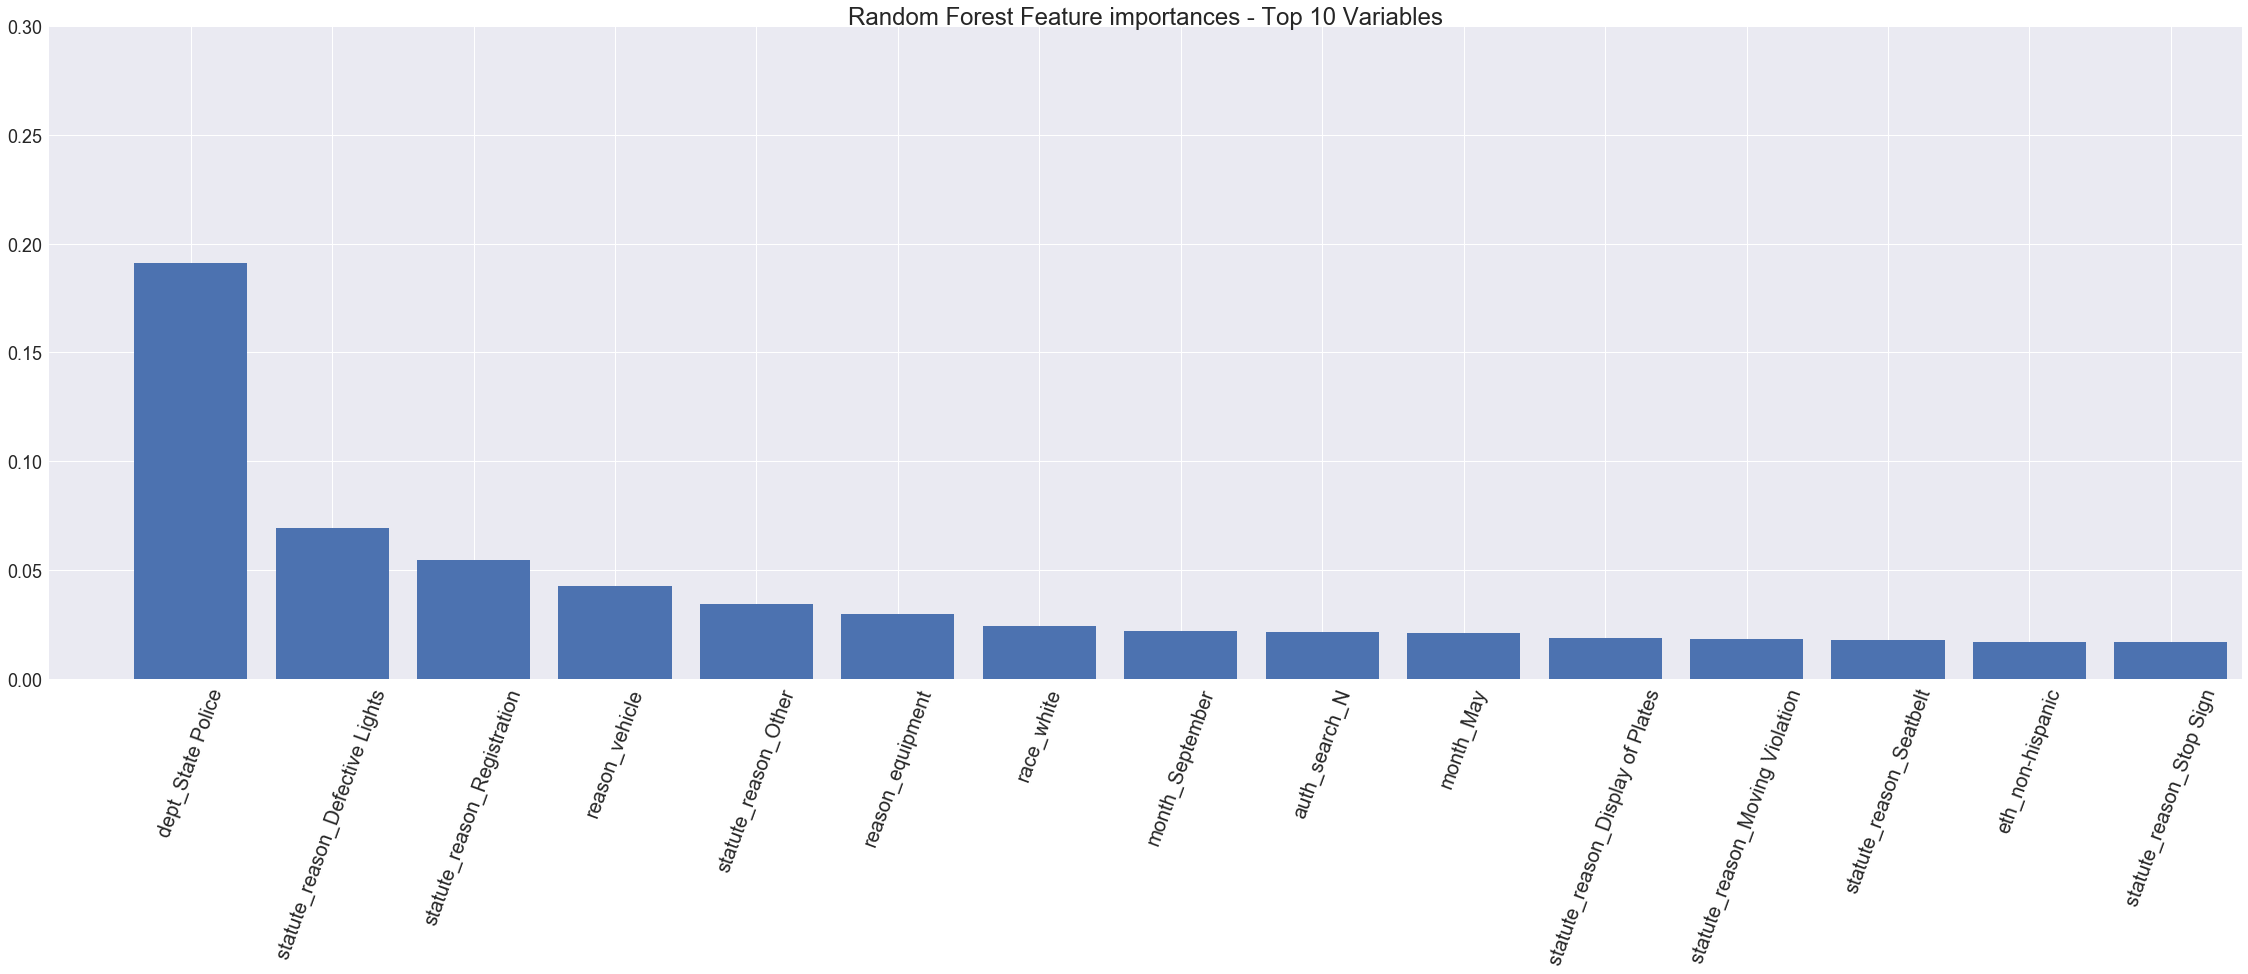

In [168]:
# Determine and display top feature importances
# from Random Forest Classification
rand_forest_class.fit(X,Y)
importances = rand_forest_class.feature_importances_
std = np.std([rand_forest_class.feature_importances_ for tree in rand_forest_class.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Random Forest Feature importances - Top 10 Variables", fontsize=24)
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=70, fontsize=20)
plt.yticks(fontsize=18)
plt.xlim([-1, 14.5])
plt.ylim([0, 0.3])
plt.show()

### PCA and Random Forest Classifier

In [169]:
def PCA_and_crossval(input_df, n, target, no_folds):
    start_time = time.time()
    from sklearn.decomposition import PCA
    from sklearn import ensemble
    from sklearn.model_selection import cross_val_score 
    
    sklearn_pca = PCA(n_components=n)    
    X_sklearn = sklearn_pca.fit_transform(input_df)
    print('The % of total variance in the dataset explained by each component from SKlearn PCA:\n',
      sklearn_pca.explained_variance_ratio_)
    print('\n Time taken for PCA transform: {} minutes. \n'.format
          ('%.3f' % ((time.time() - start_time) / 60)))
    print('---------------------------------------------------------------------------------\n')
    start_time = time.time()
    from sklearn import ensemble
    from sklearn.model_selection import cross_val_score
    rand_forest_class = ensemble.RandomForestClassifier()
    cvs = cross_val_score(rand_forest_class, X_sklearn, np.array(target).ravel(), cv=no_folds)
    print(cvs)
    print('\n Time taken for Cross-Validation: {} minutes. \n'.format
          ('%.1f' % ((time.time() - start_time) / 60)))
    print('Average Accuracy: {}'.format('%.5f' % cvs.mean()))
    print('SD of Accuracy: {}'.format('%.5f' % cvs.std()))

In [170]:
# State Input DataFrame, no. of components, Target DataFrame, no. of folds:
PCA_and_crossval(X, 5, Y, 10)

The % of total variance in the dataset explained by each component from SKlearn PCA:
 [ 0.15019004  0.12924318  0.0888298   0.07519566  0.03777541]

 Time taken for PCA transform: 0.019 minutes. 

---------------------------------------------------------------------------------

[ 0.7349486   0.73014319  0.7346714   0.72891935  0.7323461   0.73271325
  0.73797577  0.73956676  0.73378213  0.74320685]

 Time taken for Cross-Validation: 0.1 minutes. 

Average Accuracy: 0.73483
SD of Accuracy: 0.00414


### PCA and RFC - Precision, Recall, AUC

In [171]:
# PCA and RFC Precision and Recall
sklearn_pca = PCA(n_components=5)    
X_sklearntrain = sklearn_pca.fit_transform(X_train)
X_sklearntest = sklearn_pca.fit_transform(X_test)
rand_forest_class.fit(X_sklearntrain, Y_train)
pred_y = rand_forest_class.predict(X_sklearntest)
confusion_matrix(pred_y, Y_test)

array([[2107, 1384],
       [1671, 3008]], dtype=int64)

In [172]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.60      0.56      0.58      3778
          1       0.64      0.68      0.66      4392

avg / total       0.62      0.63      0.62      8170



In [173]:
# AUC curve:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.74857712817337752

### Support Vector Machines

In [174]:
start_time = time.time()
from sklearn.svm import SVC
svc = SVC()
svc.fit(X,Y)
print('Time taken: {} minutes.'.format('%.1f' % ((time.time() - start_time) / 60)))

Time taken: 21.8 minutes.


In [175]:
start_time = time.time()
from sklearn.model_selection import cross_val_score
# Or could use np.array(Y).reshape(len(Y),) instead of np.array(Y).ravel():
score = cross_val_score(svc, X, np.array(Y).ravel(), cv=10)
print(score)
print('\n Average accuracy: {}'.format('%.4f' %(sum(score)/len(score))))
print('SD of accuracy: {}'.format('%.5f' % np.std(score)))
print('-' * 50)
print('\n Time taken: {} minutes.'.format('%.1f' % ((time.time() - start_time) / 60)))

[ 0.73580519  0.7323461   0.73308041  0.74103537  0.73185657  0.73418186
  0.73393709  0.73748623  0.72888617  0.7375765 ]

 Average accuracy: 0.7346
SD of accuracy: 0.00329
--------------------------------------------------

 Time taken: 148.5 minutes.


### SVC - Precision, Recall, AUC

In [176]:
svc.fit(X_train, np.array(Y_train).ravel())
y_pred = svc.predict(X_test)
confusion_matrix(pred_y, np.array(Y_test).ravel())

array([[2107, 1384],
       [1671, 3008]], dtype=int64)

In [177]:
print(classification_report(np.array(Y_test).ravel(), pred_y))

             precision    recall  f1-score   support

          0       0.60      0.56      0.58      3778
          1       0.64      0.68      0.66      4392

avg / total       0.62      0.63      0.62      8170



In [178]:
# AUC curve:
precision, recall, thresholds = precision_recall_curve(np.array(Y_test).ravel(), pred_y)

auc(recall, precision)

0.74857712817337752

### Gradient Boosting Classifier

In [179]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [180]:
params = {'n_estimators': 50,
          'max_depth': 10,
          'loss': 'deviance'}

In [181]:
start_time = time.time()
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, Y)
score = cross_val_score(clf, X, np.array(Y).ravel(), cv=10)
print(score)
print('Average accuracy: {}'.format('%.5f' % (sum(score)/len(score))))
print('SD of accuracy: {}'.format('%.5f' % np.std(score)))
print('-' * 50)
print('Time taken: {} minutes.'.format('%.1f' % ((time.time() - start_time) / 60)))

[ 0.74192364  0.7384653   0.74544119  0.74519643  0.74152491  0.74764411
  0.74715457  0.74862318  0.74088127  0.75214198]
Average accuracy: 0.74490
SD of accuracy: 0.00396
--------------------------------------------------
Time taken: 11.8 minutes.


### Gradient Boosting Classifier - Precision, Recall, AUC

In [182]:
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)
pred_y = clf.predict(X_test)
confusion_matrix(Y_test, pred_y)

array([[2747, 1031],
       [ 991, 3401]], dtype=int64)

In [183]:
print(classification_report(Y_test, pred_y))

             precision    recall  f1-score   support

          0       0.73      0.73      0.73      3778
          1       0.77      0.77      0.77      4392

avg / total       0.75      0.75      0.75      8170



In [184]:
# AUC curve:
precision, recall, thresholds = precision_recall_curve(Y_test, pred_y)

auc(recall, precision)

0.83151677653063949

---
## Results

Many combinations of input parameters and sample size were tried. What you see below is a summary of the best of these results for each model type, for a 10% sample of the dataset (approx. 85,000 records). For reasons of brevity, all model/parameter combinations cannot be shown but the findings can be investigated by changing the sample and model parameters earlier in this notebook. The only model for which no results are shown is the Support Vector Classifier, which was abandoned as it was found to be impractically slow. <br/> <br/>The preferred model, and the winner in this analysis, is K-Nearest Neighbors, which gave the best combination of precision, recall, consistency and recall.<br/>

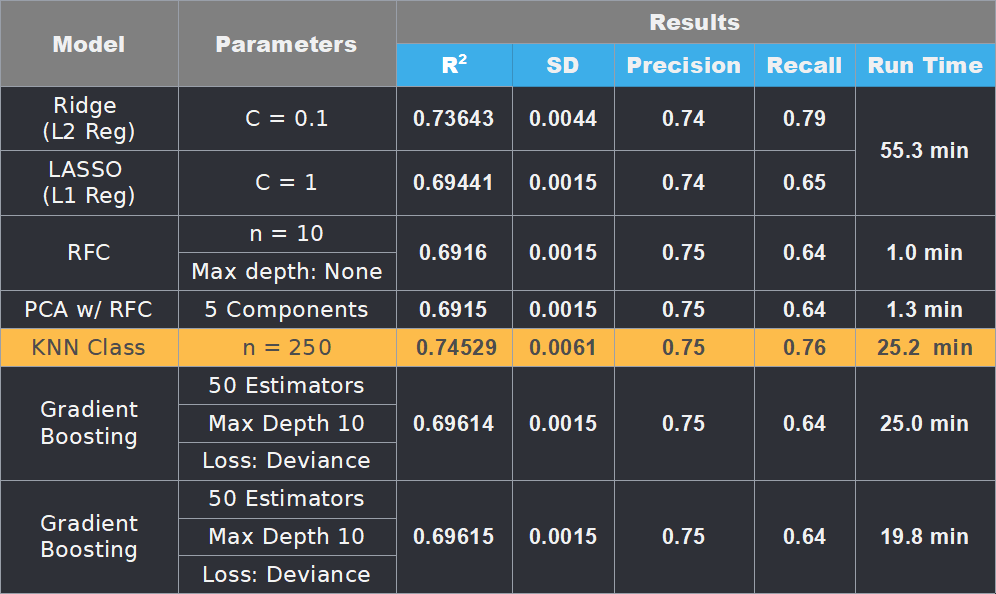

In [185]:
Image(filename='C://Users//fergu//results_table.png', width=600, height=750)

## Conclusions

It has been shown in this study that implicit bias is in fact present in the subject dataset to a statistically significant degree. The findings in this report, and the accompanying supervised learning models, could be a useful analytical tool for police departments across the US in ongoing efforts to identify and address racial bias within their own ranks.

Recalling the [hypotheses](#Hypotheses) at the beginning of this report:

<div class="alert alert-block alert-info"> 
1. Racial bias plays a role in at least some aspects of some interactions on the road between police and motorists.

</div>

In response, we can point to the [following observations from the t-tests](#t-Testing) as affirmation of this hypothesis:

- Black drivers are stopped at a higher rate than their proportion of the CT population (14.1% vs. 11.5%)
- Black and Latino males are more likely to be searched even when the stop is for a non-investigative reason
- Searches of white males most likely to yield contraband
- Females (most of all white) more likely to be let off for minor infractions. Least likely by far: Latino males.

<div class="alert alert-block alert-info">

2. The outcome of interactions between police and motorists can be statistically modeled and predicted as a function of demographic factors, specifically race.
</div>

- Race ‘black’ or ‘latino’ does correlate positively with punitive outcomes.

- Race ‘white’ correlates negatively with punitive outcomes.
<BR/>
The overall conclusions from this study are as follows:
<BR/><BR/>
- Results indicate that racial bias does appear to play a part in some of the interactions between police and road users. 
- Outcomes of these traffic stops can to some degree be modeled along racial lines, as evidenced by correlations between outcome and race 'black', race 'latino', and race 'white' in the correlation matrix. However, there are other features and factors more influential than race, although they all relate to the department or the offence, not to the subject.    

## Further Study
The main limitations of this study arise from time constraints. A future study could look at the role of geographical location, down to the lat and long coordinates. This could be even more insightful if house prices were taken into account. <BR/>For example, for a given racial group, the expected value of the outcome could be compared between higher- and lower property-value neighborhoods, holding other factors constant. On a wider scale, it would be interesting to compare trends observed in Connecticut with other states and regions around the US. 